# Integrating scRNA-seq data with PPI networks to study cell type-specific expression patterns in Alzheimer

This study aims to construct cell type-specific PPI networks, analyze differentially expressed genes (DEGs), and evaluate how gene expression patterns vary across cell types in Alzheimer.

In [599]:
import scanpy as sc
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from pandas.plotting import table
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import norm
from matplotlib.patches import Rectangle
from adjustText import adjust_text
from scipy.stats import zscore
import random
import glob
import gseapy as gp
import os
import json

import functions_proximity

## 1.  Load data

The original dataset includes cells from multiple conditions (Normal, Alzheimer's, FTD, PSP). For this analysis, we are only interested in comparing Normal vs Alzheimer's, so these two conditions are filtered out.

In [2]:
adata = sc.read_h5ad('CellXGene/cross-dementia/cross-dementia.h5ad')

KeyboardInterrupt: 

In [ ]:
# Filter by Normal y Alzheimer
adata = adata[adata.obs['disease'].isin(['normal', 'Alzheimer disease'])]

In [1]:
print("\n✅ Observations summary:")
print(f"Total number of cells: {adata.n_obs}")
print(f"Total number of cellular types: {adata.obs['cell_type'].nunique()}")
print(f"Total number of unique tissues: {adata.obs['tissue'].nunique()}")
print(f"Total number of states: {adata.obs['disease'].nunique()}")

print("\n✅ Variables summary:")
print(f"Total number of genes: {adata.n_vars}")
print(f"Number of highly variable genes: {adata.var['vst.variable'].sum()}")


✅ Observations summary:


NameError: name 'adata' is not defined

## 2. Data preprocessing

### 2.1. Filter genes

Filter genes expressed in a minimum of 10 cells and filter cells which do not express at least 200 genes. These genes are often technical noise or of little biological relevance in the context of interest.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)

In [ ]:
print(f"Total number of cells after filtering: {adata.n_obs}")

In [ ]:
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
print(f"Total number of genes after filtering: {adata.n_vars}")

### 2.2. Normalization and log transformation

**Normalization** is performed because the raw RNA-seq counts depend on the sequencing depth. Therefore, the sum of counts per cell is normalised to a constant value (10,000). This allows comparison between cells with different sequencing depths.

In addition, **log-transformation (log1p)** is applied to stabilise the variance and reduce the impact of genes with extreme high abundance.

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
sc.pp.log1p(adata)

In [13]:
adata.write('CellXGene/cross-dementia/preprocessed_data.h5ad')

## 2.3. Dataset division



In [3]:
adata = sc.read_h5ad('CellXGene/cross-dementia/preprocessed_data.h5ad')

In [4]:
print(adata.obs['cell_type'].value_counts())
print(adata.obs['disease'].value_counts())

cell_type
oligodendrocyte                      76181
glutamatergic neuron                 60845
astrocyte                            32390
inhibitory interneuron               18662
oligodendrocyte precursor cell       14054
microglial cell                      10818
endothelial cell of vascular tree     3017
pericyte                               925
T cell                                 136
Name: count, dtype: int64
disease
Alzheimer disease    118234
normal                98794
Name: count, dtype: int64


In [5]:
cell_types = adata.obs['cell_type'].unique()

# Create a dictionary to save the data for each cell type
data_per_type = {}
for type in tqdm(cell_types, desc="Procesing cell types"):
    data_per_type[type] = adata[adata.obs['cell_type'] == type].copy()

Procesing cell types: 100%|██████████| 9/9 [03:05<00:00, 20.61s/it]


In [6]:
data_per_type

{'astrocyte': AnnData object with n_obs × n_vars = 32390 × 28215
     obs: 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'ct_subcluster', 'library_id', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
     uns: 'citation', 'log1p', 'schema_reference', 'schema_version', 'title'
     obsm: 'X_pca', 'X_tsne', 'X_umap',
 'glutamatergic neuron': AnnData object with n_obs × n_vars = 60845 × 28215
     obs: 'organi

## 3. Differential expression analysis

Scanpy, when running sc.tl.rank_genes_groups(), automatically prioritises adata.raw if it exists. In this case, we saved the raw array in adata.raw to begin with (which is correct), but Scanpy is using that raw array instead of the normalised, log-transformed .X array.



**sc.tl.rank_genes_groups te da los genes más diferencialmente expresados entre los grupos comparados. El signo de logfoldchanges indica si el gen está más expresado en el grupo de interés o en el grupo de referencia. Si comparas "normal" vs "Alzheimer", un gen sobreexpresado en normal tendrá un logFC positivo para "normal" y un logFC negativo para "Alzheimer". Lo mismo al revés. El set de genes DEGs es el mismo, solo cambia el signo según qué grupo tomes como referencia.**

In [7]:
for type, adata_type in tqdm(data_per_type.items(), desc= 'Analyzing cell types...'):

    adata_normal = adata_type[adata_type.obs['disease'] == 'normal'].copy()
    adata_disease = adata_type[adata_type.obs['disease'] == 'Alzheimer disease'].copy()

    # IMPORTANT: forge use of log normalize X data.
    adata_type.raw = None

    # Differential expression analysis with wilcoxon, using the normal expression as baseline
    sc.tl.rank_genes_groups(adata_type, groupby='disease', method='wilcoxon', reference='normal')

    # Extract results of DEGs for "disease"" condition (compared to normal)
    degs_disease = sc.get.rank_genes_groups_df(adata_type, group='Alzheimer disease')

    # Filter by logFC y p-adj
    degs_disease_filtered = degs_disease[
        (degs_disease['logfoldchanges'].abs() >= 0.25) &
        (degs_disease['pvals_adj'] <= 0.05)
    ]

    print(f'{len(degs_disease_filtered)} DEGs found for {type} for Alzheimer disease')

    degs_disease_filtered.to_csv(f'CellXGene/cross-dementia/complete/data/degs_{type}_total.csv', index=False)

Analyzing cell types...:  11%|█         | 1/9 [02:11<17:30, 131.28s/it]

3712 DEGs found for astrocyte for Alzheimer disease


Analyzing cell types...:  22%|██▏       | 2/9 [08:22<31:45, 272.28s/it]

5467 DEGs found for glutamatergic neuron for Alzheimer disease


Analyzing cell types...:  33%|███▎      | 3/9 [09:01<16:35, 165.95s/it]

2193 DEGs found for oligodendrocyte precursor cell for Alzheimer disease


Analyzing cell types...:  44%|████▍     | 4/9 [16:45<23:37, 283.57s/it]

4002 DEGs found for oligodendrocyte for Alzheimer disease


Analyzing cell types...:  56%|█████▌    | 5/9 [17:48<13:36, 204.07s/it]

4878 DEGs found for inhibitory interneuron for Alzheimer disease


Analyzing cell types...:  67%|██████▋   | 6/9 [18:16<07:12, 144.03s/it]

1722 DEGs found for microglial cell for Alzheimer disease


Analyzing cell types...:  78%|███████▊  | 7/9 [18:23<03:18, 99.43s/it] 

389 DEGs found for endothelial cell of vascular tree for Alzheimer disease


Analyzing cell types...:  89%|████████▉ | 8/9 [18:25<01:08, 68.44s/it]

113 DEGs found for pericyte for Alzheimer disease


Analyzing cell types...: 100%|██████████| 9/9 [18:26<00:00, 122.90s/it]

1 DEGs found for T cell for Alzheimer disease


## 4. Individualized-PPI construction per cell type

### 4.1. Gene-protein mapping

In this case, scRNA-seq data uses ENSEMBL ID to identify genes, and our mapping file uses Entrez ID. First we perform a step in order to transform the identifiers using NCBI API.


In [148]:
gen = pd.read_csv('CellXGene/gen.tsv', sep = '\t')
gen_pro = pd.read_csv('CellXGene/gen_pro.tsv', sep = '\t')

In [149]:
def obtain_gene_symbol(ensembl_ids, type):
    """
    Function that, given a list of ensembl ids, searches for the gene symbols in the ensembl api
    """
    base_url = "https://rest.ensembl.org/lookup/id/"

    gene_symbols = {}

    for ensembl_id in tqdm(ensembl_ids, desc = f'Processing ensembl ids for cell type {type}...'):
        url = f"{base_url}{ensembl_id}?content-type=application/json"
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            gene_symbol = data.get('display_name', None)
            gene_symbols[ensembl_id] = gene_symbol
        else:
            print(f"Error obtaining data for {ensembl_id}: {response.status_code}")
            gene_symbols[ensembl_id] = None

    return gene_symbols

In [150]:
def map_gene_symbols_to_entrez(gene_symbols, gen_file):
    """
    Function to map gene symbols to Entrez IDs. You would replace this with your preferred method/API call.
    """
    symbol_to_entrez = dict(zip(gen_file['gene_symbol'], gen_file['gene_id']))

    # Mapear los Gene Symbols a Entrez IDs
    #entrez_ids = {ensembl_id: symbol_to_entrez.get(gene_symbol, None) for ensembl_id, gene_symbol in gene_symbols.items()}
    entrez_ids = {}
    for ensembl_id, gene_symbol in gene_symbols.items():
        entrez_ids[ensembl_id] = (gene_symbol, symbol_to_entrez.get(gene_symbol, None))

    return entrez_ids

In [151]:
sample_type = 'pericyte'

# Obtén el valor correspondiente a esa key
data_for_sample_type = {sample_type: data_per_type[sample_type]}
data_for_sample_type

{'pericyte': AnnData object with n_obs × n_vars = 925 × 28215
     obs: 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'ct_subcluster', 'library_id', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
     uns: 'citation', 'log1p', 'schema_reference', 'schema_version', 'title'
     obsm: 'X_pca', 'X_tsne', 'X_umap'}

In [152]:
#for type, adata_type in data_per_type.items():
for type, adata_type in tqdm(data_for_sample_type.items(), desc=f'Mapping DEGs for {sample_type}...'):

    # Load DEGs for the cellular type
    degs_disease_filtered = pd.read_csv(f'CellXGene/cross-dementia/complete/data/degs_{type}_total.csv')

    # Obtain ENSEMBL IDs from the DEGs
    ensembl_ids_disease = degs_disease_filtered['names'].tolist()

    # Map ENSEMBL -> Gene symbol
    symbol_ids_disease = obtain_gene_symbol(ensembl_ids_disease, type)

    # Map Gene symbol -> Entrez
    gene_symbol_entrez = map_gene_symbols_to_entrez(symbol_ids_disease, gen)

    # Map DEGs with respective Entrez IDs
    #degs_disease_filtered['gene_id'] = degs_disease_filtered['names'].map(entrez_ids_disease)
    degs_disease_filtered['gene_symbol'] = degs_disease_filtered['names'].map(lambda x: gene_symbol_entrez[x][0])
    degs_disease_filtered['gene_id'] = degs_disease_filtered['names'].map(lambda x: gene_symbol_entrez[x][1])

    # Reorder columns
    column_order = ['gene_id', 'gene_symbol', 'names', 'logfoldchanges', 'pvals', 'pvals_adj', 'scores']
    degs_disease_filtered = degs_disease_filtered[column_order]

    degs_disease_filtered.to_csv(f'CellXGene/cross-dementia/complete/data/degs_{type}_mapped.csv', index=False)

Mapping DEGs for pericyte...:   0%|          | 0/1 [00:00<?, ?it/s]
Processing ensembl ids for cell type pericyte...:   0%|          | 0/113 [00:00<?, ?it/s]
Processing ensembl ids for cell type pericyte...:   1%|          | 1/113 [00:02<03:46,  2.02s/it]
Processing ensembl ids for cell type pericyte...:   2%|▏         | 2/113 [00:05<04:49,  2.60s/it]
Processing ensembl ids for cell type pericyte...:   3%|▎         | 3/113 [00:06<03:25,  1.87s/it]
Processing ensembl ids for cell type pericyte...:   4%|▎         | 4/113 [00:09<04:44,  2.61s/it]
Processing ensembl ids for cell type pericyte...:   4%|▍         | 5/113 [00:10<03:09,  1.75s/it]
Processing ensembl ids for cell type pericyte...:   5%|▌         | 6/113 [00:13<04:06,  2.30s/it]
Processing ensembl ids for cell type pericyte...:   6%|▌         | 7/113 [00:13<03:04,  1.74s/it]
Processing ensembl ids for cell type pericyte...:   7%|▋         | 8/113 [00:17<03:47,  2.17s/it]
Processing ensembl ids for cell type pericyte...:   8%|▊  

In [162]:
def add_protein_id(file_path):
    df = pd.read_csv(file_path)
    df['protein_id'] = df['gene_id'].map(gene_to_protein)
    column_order = ['protein_id', 'gene_id', 'gene_symbol', 'names', 'logfoldchanges', 'pvals', 'pvals_adj', 'scores']
    df = df[column_order]
    df.to_csv(file_path, index=False)

In [164]:
gene_to_protein = dict(zip(gen_pro['gene_id'], gen_pro['protein_id']))
# keys = ['astrocyte', 'glutamatergic neuron', 'oligodendrocyte precursor cell', 'oligodendrocyte', 'inhibitory interneuron', 'microglial cell']
keys = ['pericyte']

for type in keys:
    print(type)
    mapped_file_path = f'CellXGene/cross-dementia/complete/data/degs_{type}_mapped.csv'
    add_protein_id(mapped_file_path)

pericyte


### 4.2. Cell type-specific PPI construction and integration of DEGs expression values


**Las PPI específicas de tipo celular y condición (sana/enferma) van a ser iguales en estructura (mismos nodos y edges) porque usas el mismo set de DEGs, solo que cambia el contexto de up/down-regulation. Se está filtrando el interactoma general (pro_pro.tsv) para quedarte con las interacciones entre DEGs.**

Si los mismos genes aparecen como DEGs en ambas condiciones (solo cambia el signo del logFC), el set de proteínas mapeadas será el mismo.
Eso implica que la topología (estructura) de la red será igual entre sano y enfermo.

Problema: No estás capturando cambios estructurales reales entre las redes de condiciones sanas y enfermas. Solo podrías distinguirlas después (en análisis como enrichment o modularidad) considerando el estado up/down de los nodos, pero no en la conectividad.

In [221]:
gen_pro = pd.read_csv("CellXGene/gen_pro.tsv", sep='\t')
pro_pro = pd.read_csv('CellXGene/pro_pro.tsv', sep = '\t')

In [222]:
sample_type = 'astrocyte'

# Obtén el valor correspondiente a esa key
data_for_sample_type = {sample_type: data_per_type[sample_type]}

In [225]:
def build_ppi_with_expression(cell_type, gen_pro, pro_pro):
    """
    Construye la red PPI específica de un tipo celular, filtrada por DEGs,
    e integra los valores de expresión diferencial directamente en los nodos.

    Parámetros:
    - cell_type: str, nombre del tipo celular.
    - gen_pro: DataFrame, mapeo gene_id → protein_id.
    - pro_pro: DataFrame, interacciones proteína-proteína.

    Output:
    - G: Grafo NetworkX con expresión diferencial integrada.
    """
    # Cargar los DEGs para este tipo celular
    degs = pd.read_csv(f"CellXGene/cross-dementia/complete/data/degs_{cell_type}_mapped.csv")

    # Mapear genes DEGs a proteínas (usando Entrez IDs)
    degs = degs.merge(gen_pro, on="gene_id", how="left")

    # Lista de proteínas DEGs
    proteins_degs_disease = degs["protein_id"].dropna().unique()

    # Filtrar la red PPI para solo conservar interacciones entre proteínas DEGs y eliminar self-interactions
    ppi_filtered_disease = pro_pro[
        (pro_pro["prA"].isin(proteins_degs_disease)) &
        (pro_pro["prB"].isin(proteins_degs_disease)) &
        (pro_pro["prA"] != pro_pro["prB"])
    ]

    # Construir la red PPI
    G = nx.from_pandas_edgelist(ppi_filtered_disease, "prA", "prB")

    # Agregar la expresión diferencial a los nodos de la red
    for _, row in degs.iterrows():
        if row["protein_id"] in G:
            G.nodes[row["protein_id"]]["gene_id"] = row["gene_id"]
            G.nodes[row["protein_id"]]["gene_symbol"] = row["gene_symbol"]
            G.nodes[row["protein_id"]]["logfoldchanges"] = row["logfoldchanges"]
            G.nodes[row["protein_id"]]["pval"] = row["pvals"]
            G.nodes[row["protein_id"]]["pval_adj"] = row["pvals_adj"]

    # Guardar la red en un único archivo con expresión integrada
    output_path = f"CellXGene/cross-dementia/complete/graphs/{cell_type}_network.graphml"
    nx.write_graphml(G, output_path)

    return G

In [226]:
cell_networks = {
    cell: build_ppi_with_expression(cell, gen_pro, pro_pro)
    for cell in tqdm(data_per_type.keys(), desc="Building cell type-specific PPIs with expression values...")
}

Building cell type-specific PPIs with expression values...: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


## 5. Integrated analysis of DEG overlap and presence in the alzheimer module by cell type

### 5.1. Obtain Alzheimer disease module

Calculate the disease module for Alzheimer's disease.



In [10]:
dis_gen = pd.read_csv('CellXGene/dis_gen.tsv', sep = '\t')
gen_pro = pd.read_csv('CellXGene/gen_pro.tsv', sep = '\t')
pro_pro = pd.read_csv('CellXGene/pro_pro.tsv', sep = '\t')

In [11]:
G_ppi = nx.from_pandas_edgelist(pro_pro, 'prA', 'prB')

In [12]:
def get_disease_module(disease, dis_gen, gen_pro, pro_pro, PPI):

    genes = functions_proximity.genes_dis(disease, dis_gen)
    prots = functions_proximity.pro_gen_dict(genes, gen_pro)
    prots_interactome = functions_proximity.gen_pro_PPI(prots, pro_pro)
    SG = PPI.subgraph(prots_interactome)
    lcc = functions_proximity.lcc(SG)

    return lcc

In [13]:
lcc_alz = get_disease_module('C0002395', dis_gen, gen_pro, pro_pro, G_ppi)

In [14]:
lcc_alz

{'P52209',
 'O43189',
 'Q9NZQ7',
 'Q9NZV6',
 'P51843',
 'Q16795',
 'Q9HCE0',
 'P35638',
 'P04406',
 'O15427',
 'P03891',
 'Q9ULV8',
 'P35232',
 'P00813',
 'Q9UIK4',
 'P63244',
 'O75689',
 'O15105',
 'P51688',
 'Q9BXY0',
 'Q9BYF1',
 'Q53EL6',
 'P24387',
 'P42768',
 'P15529',
 'P60228',
 'Q9UHC9',
 'Q9P2Y5',
 'P12004',
 'Q6ZW49',
 'Q4V9L6',
 'P49716',
 'P04179',
 'Q9Y2A7',
 'Q13200',
 'Q9NV58',
 'O94813',
 'Q05086',
 'P12314',
 'Q8N5C8',
 'P08311',
 'O95452',
 'P78556',
 'O15379',
 'P25942',
 'P46937',
 'P16520',
 'P60983',
 'P02794',
 'Q5SNT2',
 'Q9UBW5',
 'O14578',
 'Q13133',
 'Q92847',
 'Q9GZX9',
 'P26599',
 'O15121',
 'Q9Y5N1',
 'Q9UMD9',
 'P20138',
 'Q15027',
 'Q9NTU7',
 'O75716',
 'O14595',
 'Q9H6U6',
 'P22033',
 'O14734',
 'Q8IXL6',
 'P48147',
 'P46734',
 'P35354',
 'Q14573',
 'P24863',
 'P05112',
 'Q9UKI9',
 'P04062',
 'P04439',
 'Q9Y3D2',
 'P23945',
 'Q9Y4C0',
 'P38936',
 'P10145',
 'Q8IYK4',
 'Q86TM6',
 'Q9NXA8',
 'Q9Y6H1',
 'Q02246',
 'Q9NZC7',
 'P63220',
 'Q9UNU6',
 'Q9UJY1',

### 5.2. Alzheimer module proteins filtering

Keep only those proteins which are present in the Alzheimer disease module for subsequent analysis.


In [ ]:
for cell_type in tqdm(cell_types, desc='Processing cell types...'):

    # Cargar red PPI específica para este tipo celular
    G = nx.read_graphml(f'CellXGene/cross-dementia/complete/graphs/{cell_type}_network.graphml')
    ppi_proteins = set(G.nodes())

    # Proteínas del módulo de Alzheimer presentes en la PPI de este tipo celular
    alz_in_ppi = lcc_alz.intersection(ppi_proteins)

    G_alz = G.subgraph(alz_in_ppi).copy()
    nx.write_graphml(G_alz, f'CellXGene/cross-dementia/filtered/graphs/{cell_type}_network.graphml')

    # Archivo filtrado de mapped genes
    df_complete = pd.read_csv(f'CellXGene/cross-dementia/complete/data/degs_{cell_type}_mapped.csv')

    alz_data = [{
        "protein_id": protein,
        "gene_id": G.nodes[protein].get("gene_id", "NA"),
        "gene_symbol": G.nodes[protein].get("gene_symbol", "NA")
    } for protein in alz_in_ppi]

    df_alz = pd.DataFrame(alz_data)

    df_filtered = df_alz.merge(df_complete, on=["gene_id"], how="left")
    df_filtered = df_filtered[df_filtered['protein_id'].isin(G_alz.nodes)]
    df_filtered = df_filtered.drop(columns=["gene_symbol_x"], errors='ignore')
    df_filtered = df_filtered.rename(columns={"gene_symbol_y": "gene_symbol"})

    df_filtered.to_csv(f'CellXGene/cross-dementia/filtered/data/degs_{cell_type}_mapped.csv', index=False)

In [359]:
len(lcc_alz)

2697

## 6. Cell type-specific network and Alzheimer module overlap

This analysis investigates the relationship between differentially expressed genes (DEGs) and the Alzheimer disease module (defined as the largest connected component of a protein-protein interaction network associated with Alzheimer’s disease) across different cell types.

- Cell Type
- Total DEGs: numero total de DEGs en el dataset original
- DEGs mapped to protein: numero de los DEGs totales codificados a proteinas
- Cell Type proteins in main LCC: numero de proteinas que vienen de DEGs del tipo celular específico que se encuentran en el modulo del Alzheimer
- Cell Type LCC size: tamaño del modulo de la enfermedad de la subred especifica del tipo celular
- LCC mean: media del tamaño de los 1,000 modulos aleatorios generados
- LCC std: desviación estándar del tamaño de los 1,000 modulos aleatorios generados
- Zscore: calculado a partir del valor real del tamaño del LCC del subtipo celular (Cell Type LCC size), con la media (LCC mean) y la desviación estándar (LCC std) de los 1,000 modulos aleatorios
- p_value: calculado a partir de la conversión del zscore a partir de la distribución Z
- adjusted_p_value: calculado aplicando la corrección de Benjamini-Hochberg (FDR Correction) al p-value

**Take into account that:** if a DEG can be mapped to protein only means that there is a known protein identifier for that gene. For it to be in the PPI, it must also be in the interaction network of the specific cell type. If there are no known interactions for that protein in that context, even if it has been mapped, it will not appear in the PPI network. This is why is why the value of ‘degs_in_alzheimer_module’ is higher than that of ‘alzheimer_proteins_in_specific_ppi’. This value can be higher because it is considering all DEGs proteins that have been mapped to proteins, without the need for all of them to necessarily be present in the cell type and condition specific PPI.

In [242]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [232]:
def calculate_lcc_for_cell_type(degs_cell_type, gen_pro, pro_pro, PPI):

    # Generar la subred para el tipo celular con sus DEGs
    prots = functions_proximity.pro_gen_dict(degs_cell_type, gen_pro)  # Proteínas correspondientes a los DEGs
    prots_interactome = functions_proximity.gen_pro_PPI(prots, pro_pro)
    SG = PPI.subgraph(prots_interactome)
    lcc_cell_type = functions_proximity.lcc(SG)

    return lcc_cell_type

# =================================================================================

def calculate_lcc_from_prots(prots, pro_pro, PPI):

    prots_interactome = []
    for prot in prots:
        # Iterating over all proteins in the general prot:gen dictionary.
        if prot in pro_pro["prA"].tolist() or prot in pro_pro["prB"].tolist():
            # Selecting proteins that appear in the PPI network.
            prots_interactome.append(prot)

    SG = PPI.subgraph(prots_interactome)
    lcc_cell_type = functions_proximity.lcc(SG)

    return lcc_cell_type

# =================================================================================

def generate_log_bins(graph, num_bins):
    """
    This function generates logarithmic bins to group nodes of a graph based on
    the degree distribution of the nodes.
    """
    degrees = [degree for _, degree in graph.degree()]
    min_degree = max(min(degrees), 1)  # Para evitar log(0)
    max_degree = max(degrees)

    return np.logspace(np.log10(min_degree), np.log10(max_degree), num_bins)

# =================================================================================

def group_nodes_by_bins(graph, log_bins):
    """
    This function groups nodes of a graph in logarithmic bins based on its degree.

    Input:
    1.graph
    2. log_bins: logarithmic bins
    """
    nodes_bins = {}
    for node, degree in graph.degree():
        bin_index = np.digitize(degree, log_bins) - 1  # Ajustar índice para Python (basado en 0)
        nodes_bins.setdefault(bin_index, []).append(node)

    return nodes_bins

# =================================================================================

def random_subset_generator(proteins, graph_ppi, num_iterations):

        # Generation of logarithmic bins
    num_bins = 10
    bin_edges = generate_log_bins(graph_ppi, num_bins)

    # Group nodes in logarithmic bins
    group_nodes_bins = group_nodes_by_bins(graph_ppi, bin_edges)

    results = []

    for _ in range(num_iterations):  # For each iteration

        iteration_results = [] # list to append proteins for each disease

        for prot in proteins:

            # degree of the node
            degree_node = graph_ppi.degree(prot)

            # bin of the node based on its degree
            bin_index = np.digitize(degree_node, bin_edges) - 1

            # nodes of the same bin
            available_nodes = group_nodes_bins.get(bin_index, [])

            if available_nodes:
                random_node = np.random.choice(available_nodes) #choose randomly a node from available nodes
                # if len(available_nodes) == 1 and random_node == prot:
                #     pass
                # else:
                while random_node == prot:
                    random_node = np.random.choice(available_nodes)

                iteration_results.append(str(random_node))

            else:
                iteration_results.append(None)

        # results.append(results)
        if any(iteration_results):
            results.append(iteration_results)

    return results

Processing cell types...:   0%|          | 0/8 [00:00<?, ?it/s]

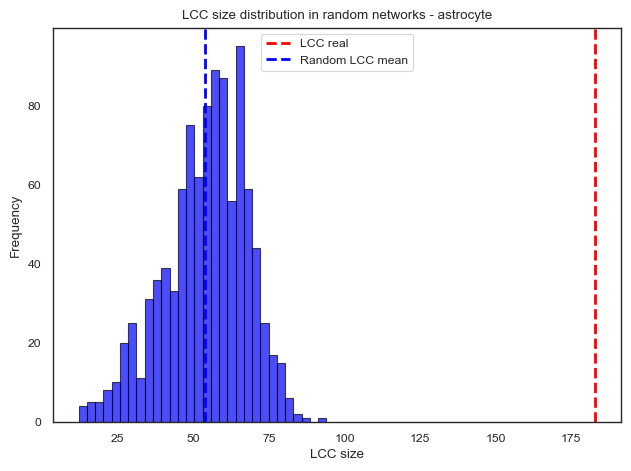

Processing cell types...:  12%|█▎        | 1/8 [18:01<2:06:12, 1081.80s/it]

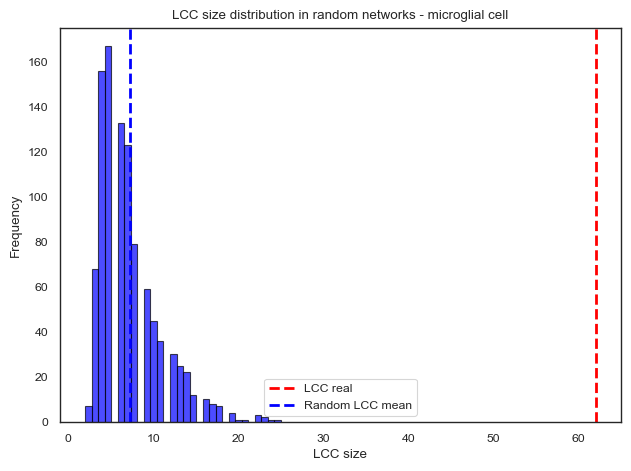

Processing cell types...:  25%|██▌       | 2/8 [23:59<1:05:34, 655.83s/it] 

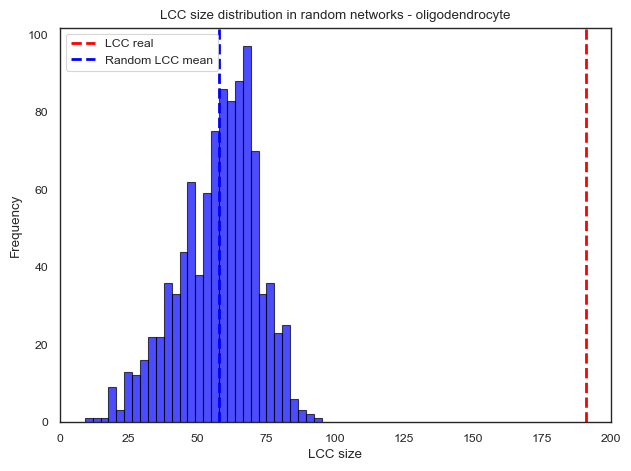

Processing cell types...:  38%|███▊      | 3/8 [43:44<1:14:47, 897.45s/it]

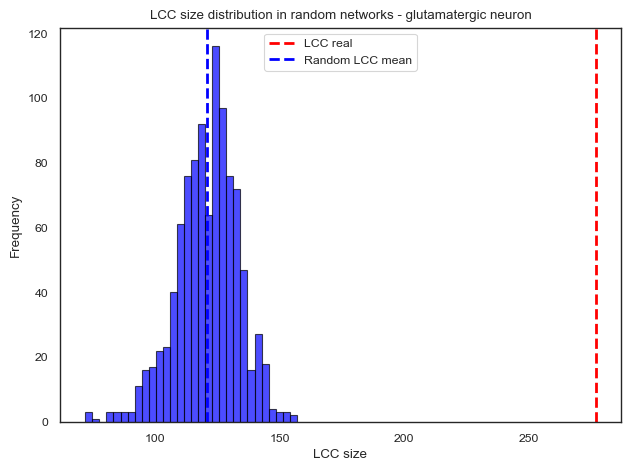

Processing cell types...:  50%|█████     | 4/8 [1:11:51<1:20:37, 1209.26s/it]

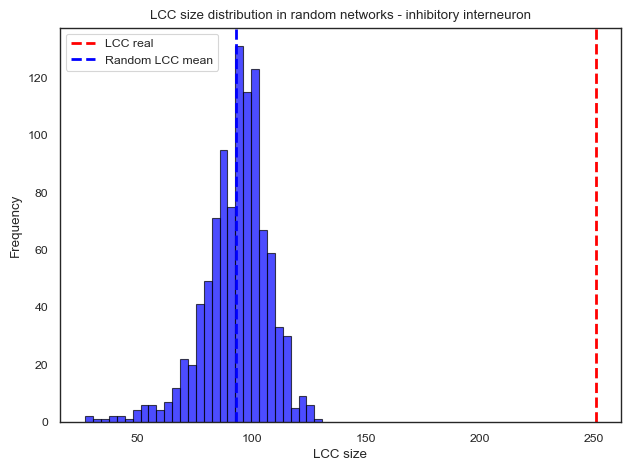

Processing cell types...:  62%|██████▎   | 5/8 [1:37:00<1:05:52, 1317.36s/it]

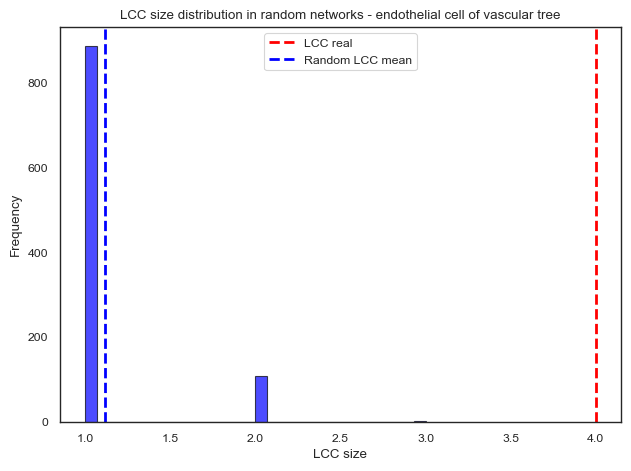

Processing cell types...:  75%|███████▌  | 6/8 [1:37:23<29:14, 877.04s/it]   

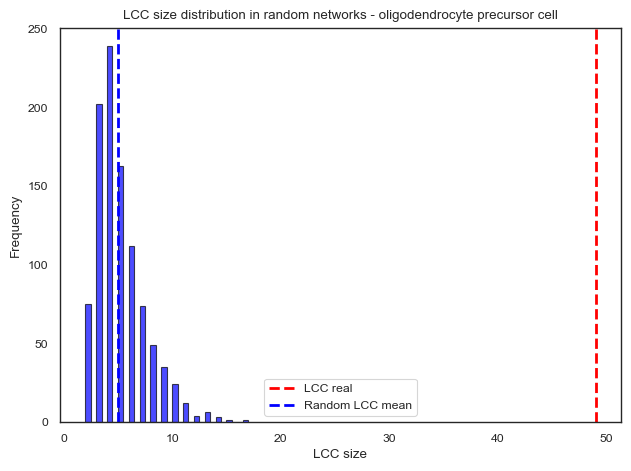

Processing cell types...:  88%|████████▊ | 7/8 [1:41:58<11:20, 680.37s/it]

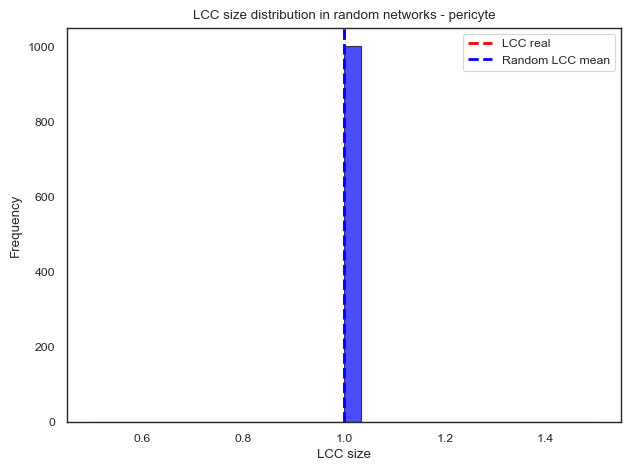

Processing cell types...: 100%|██████████| 8/8 [1:42:04<00:00, 765.58s/it]


In [243]:
table = []

for cell_type in tqdm(cell_types, desc="Processing cell types..."):

    # Solapamiento DEGs en módulo de Alzheimer: número de proteínas DEGs que están en el módulo de Alzheimer.
    degs_cell_type = pd.read_csv(f'CellXGene/cross-dementia/complete/data/degs_{cell_type}_mapped.csv')
    degs_total = degs_cell_type.dropna(subset=['gene_id'])['gene_id']
    degs_protein = degs_cell_type.dropna(subset=['protein_id'])['protein_id']

    G = nx.read_graphml(f'CellXGene/cross-dementia/complete/graphs/{cell_type}_network.graphml')
    ppi_proteins = set(G.nodes())

    # Proteínas del módulo de Alzheimer presentes en la PPI de este tipo celular
    alz_in_ppi = lcc_alz.intersection(ppi_proteins)

    # Calcular el LCC de la red de enfermedad para el tipo celular. Para ello utilizamos los DEGs que se encuentran en el LCC general de la enfermedad
    degs_cell_type_filt = pd.read_csv(f'CellXGene/cross-dementia/filtered/data/degs_{cell_type}_mapped.csv')
    lcc_cell_type = calculate_lcc_for_cell_type(degs_cell_type_filt['gene_id'], gen_pro, pro_pro, G_ppi)

    # Generar 1,000 redes aleatorias
    random_networks = random_subset_generator(lcc_cell_type, G_ppi, 1000)

    # Calcular el tamaño del LCC para cada red aleatoria
    random_lcc_sizes = [len(calculate_lcc_from_prots(network, pro_pro, G_ppi)) for network in random_networks]

    # Calcular estadísticas de los módulos aleatorios
    random_lcc_mean = np.mean(random_lcc_sizes)
    random_lcc_std = np.std(random_lcc_sizes)

    plt.hist(random_lcc_sizes, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(len(lcc_cell_type), color='red', linestyle='dashed', linewidth=2, label="LCC real")
    plt.axvline(random_lcc_mean, color='blue', linestyle='dashed', linewidth=2, label="Random LCC mean")
    plt.xlabel("LCC size")
    plt.ylabel("Frequency")
    plt.title(f"LCC size distribution in random networks - {cell_type}")
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.savefig(f'CellXGene/cross-dementia/plots/significance/random_modules_{cell_type}.svg', format='svg', dpi=1200)
    plt.show()

    # Agregar la fila correspondiente
    table.append([cell_type, len(degs_total), len(degs_protein), len(alz_in_ppi), len(lcc_cell_type), random_lcc_mean, random_lcc_std])

# Crear el DataFrame de la tabla
table_df = pd.DataFrame(table, columns=["Cell Type", "Total DEGs", "DEGs mapped to protein", "Cell Type proteins in main LCC", "Cell Type LCC size", "LCC mean", "LCC std"])

In [252]:
table_df['z_score'] = (table_df['Cell Type LCC size'] - table_df['LCC mean']) / table_df['LCC std']

Cell Type  Total DEGs  DEGs mapped to protein  \
0                          astrocyte        3176                    2878   
1                    microglial cell        1585                    1501   
2                    oligodendrocyte        3383                    3052   
3               glutamatergic neuron        4436                    3963   
4             inhibitory interneuron        4130                    3769   
5  endothelial cell of vascular tree         379                     367   
6     oligodendrocyte precursor cell        1963                    1832   
7                           pericyte         111                     107   

   Cell Type proteins in main LCC  Cell Type LCC size  LCC mean    LCC std  \
0                             532                 183    53.963  13.744804   
1                             334                  62     7.218   3.662032   
2                             554                 191    57.553  14.372585   
3                             733                 277   120.873  12.425573   
4                             673                 251    93.186  14.119752   
5                              73                   4     1.115   0.328291   
6                             320                  49     4.996   2.286916   
7                              20                   1     1.000   0.000000   

   p_value  adjusted_p_value    z_score  
0      0.0               0.0   9.388057  
1      0.0               0.0  14.959456  
2      0.0               0.0   9.284830  
3      0.0               0.0  12.564974  
4      0.0               0.0  11.176825  
5      0.0               0.0   8.787934  
6      0.0               0.0  19.241635  
7      1.0               1.0        NaN

In [253]:
table_df.to_csv('CellXGene/cross-dementia/filtered/results/cell_type_summary.tsv', sep='\t', index=False)

### P-value and Adj P-value calculation

In [272]:
df = pd.read_csv('CellXGene/cross-dementia/filtered/results/cell_type_summary.tsv', sep='\t')

In [274]:
pericyte_row = df[df['Cell Type'] == 'pericyte'].copy()

df['p_value'] = 2 * norm.sf(abs(df['z_score'])) # p value bilateral porque tengo en cuenta que los modulos aleatorios pueden ser de mayor o menos tamaño que el real
df = df.dropna(subset=['p_value'])
df['p_value'] = pd.to_numeric(df['p_value'], errors='coerce')  # Convertir a float
df['p_value'] = df['p_value'].replace(0, np.nextafter(0, 1))
df['adj_p_value'] = multipletests(df['p_value'], method='fdr_bh')[1]

pericyte_row['adj_p_value'] = np.nan  # Mantener el valor como NaN
df = pd.concat([df, pericyte_row], ignore_index=True)

df

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\868517119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_value'] = pd.to_numeric(df['p_value'], errors='coerce')  # Convertir a float
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\868517119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_value'] = df['p_value'].replace(0, np.nextafter(0, 1))
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\868517119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Cell Type  Total DEGs  DEGs mapped to protein  \
0                          astrocyte        3176                    2878   
1                    microglial cell        1585                    1501   
2                    oligodendrocyte        3383                    3052   
3               glutamatergic neuron        4436                    3963   
4             inhibitory interneuron        4130                    3769   
5  endothelial cell of vascular tree         379                     367   
6     oligodendrocyte precursor cell        1963                    1832   
7                           pericyte         111                     107   

   Cell Type proteins in main LCC  Cell Type LCC size  LCC mean    LCC std  \
0                             532                 183    53.963  13.744804   
1                             334                  62     7.218   3.662032   
2                             554                 191    57.553  14.372585   
3                             733                 277   120.873  12.425573   
4                             673                 251    93.186  14.119752   
5                              73                   4     1.115   0.328291   
6                             320                  49     4.996   2.286916   
7                              20                   1     1.000   0.000000   

     z_score       p_value   adj_p_value  
0   9.388057  6.111731e-21  8.556424e-21  
1  14.959456  1.351270e-50  4.729446e-50  
2   9.284830  1.619661e-20  1.889605e-20  
3  12.564974  3.289849e-36  7.676313e-36  
4  11.176825  5.295062e-29  9.266358e-29  
5   8.787934  1.523350e-18  1.523350e-18  
6  19.241635  1.658917e-82  1.161242e-81  
7        NaN           NaN           NaN

In [275]:
df.to_csv('CellXGene/cross-dementia/filtered/results/cell_type_summary_stats.tsv', sep='\t', index=False)

### 6.2. Representation of common proteins with DEGs values

In [21]:
def load_and_process(files):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        # Extraer el tipo celular del nombre del archivo (por ejemplo, "degs_celltype_mapped.csv")
        cell_type = file.split('_')[1]  # Asumiendo que el tipo celular está en la segunda posición del nombre del archivo
        df['cell_type'] = cell_type  # Agregar la columna 'cell_type' al DataFrame
        df_list.append(df)
    merged_df = pd.concat(df_list)
    return merged_df

In [22]:
complete_files = glob.glob("CellXGene/cross-dementia/complete/data/degs_*_mapped.csv")
filtered_files = glob.glob("CellXGene/cross-dementia/filtered/data/degs_*_mapped.csv")

# Cargar datos
complete_data = load_and_process(complete_files)
filtered_data = load_and_process(filtered_files)

In [23]:
# Calcular estadísticas por proteína
aggregated = complete_data.groupby("protein_id").agg(
    logfoldchange_mean=("logfoldchanges", "mean"),
    std_logfoldchanges=("logfoldchanges", "std"),
    num_cell_types=("cell_type", "nunique"),
    gene_symbol=("gene_symbol", "first")
).reset_index()

aggregated

protein_id  logfoldchange_mean  std_logfoldchanges  num_cell_types  \
0     A0A087WUL8            0.485817            0.215743               4   
1     A0A087WVF3           -3.359497                 NaN               1   
2     A0A0U1RRE5            0.342878            0.111791               3   
3     A0A0U1RRL7            0.288252                 NaN               1   
4     A0A1B0GTU2            1.060499                 NaN               1   
...          ...                 ...                 ...             ...   
8387      Q9Y6X6           -0.007668            0.382404               2   
8388      Q9Y6X8            0.516868            0.162532               4   
8389      Q9Y6Y0            0.595799            0.244793               4   
8390      Q9Y6Y8           -0.340800            0.078085               3   
8391      Q9Y6Z7           -1.352683                 NaN               1   

     gene_symbol  
0         NBPF19  
1        TBC1D3D  
2           NBDY  
3        MMP24OS  
4         CTXND1  
...          ...  
8387       MYO16  
8388        ZHX2  
8389    IVNS1ABP  
8390     SEC23IP  
8391     COLEC10  

[8392 rows x 5 columns]

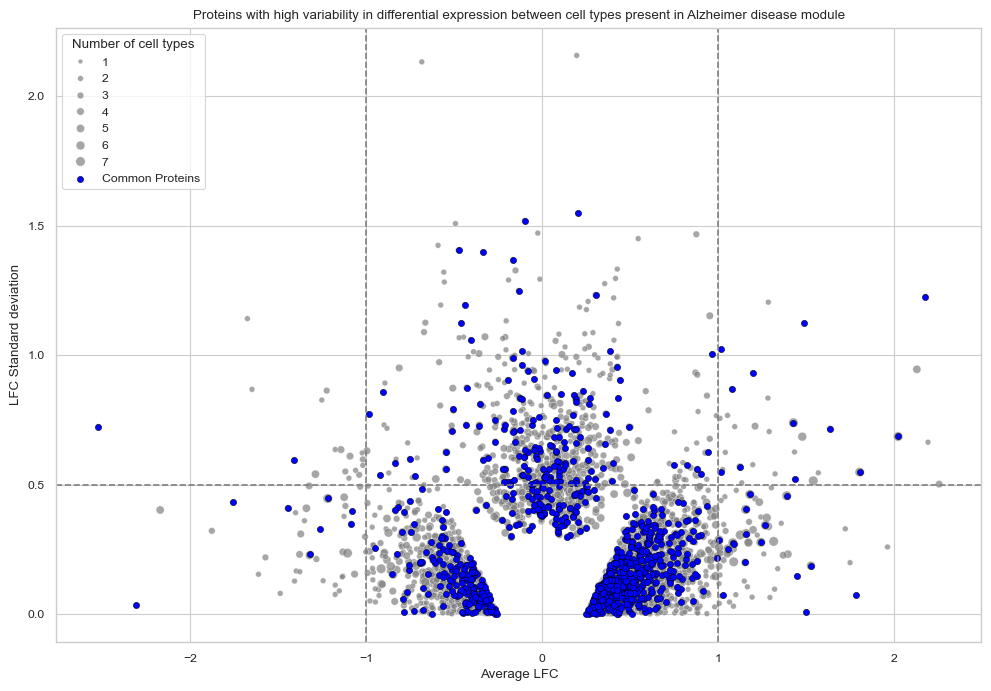

In [24]:
# Identificar proteínas comunes
common_proteins = set(complete_data["protein_id"]) & set(filtered_data["protein_id"])
aggregated["common"] = aggregated["protein_id"].isin(common_proteins)

sns.set_context("paper")
sns.set_style("whitegrid")

# Crear el scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=aggregated, x='logfoldchange_mean', y='std_logfoldchanges',
                size='num_cell_types', color='gray', alpha=0.7)

# Resaltar proteínas comunes en azul
sns.scatterplot(data=aggregated[aggregated["common"]], x='logfoldchange_mean', y='std_logfoldchanges',
                color='blue', s=20, edgecolor='black', label='Common Proteins')

plt.axvline(x=1, linestyle='--', color='gray')   # Umbral de LFC > 1
plt.axvline(x=-1, linestyle='--', color='gray')  # Umbral de LFC < -1
plt.axhline(y=0.5, linestyle='--', color='gray') # Umbral de alta variabilidad

plt.title('Proteins with high variability in differential expression between cell types present in Alzheimer disease module')
plt.xlabel('Average LFC')
plt.ylabel('LFC Standard deviation')
plt.legend(title='Number of cell types', loc='upper left')
plt.tight_layout()

plt.savefig('CellXGene/cross-dementia/plots/volcano_all.svg', format = 'svg', dpi=1200)
plt.show()

### 6.3. Representation of each cell type differential expression values

In [226]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [350]:
df['pvals_adj'].describe()

count    2.000000e+01
mean     1.649116e-02
std      1.941289e-02
min      5.375182e-20
25%      1.339488e-04
50%      7.495072e-03
75%      3.880477e-02
max      4.917496e-02
Name: pvals_adj, dtype: float64

In [528]:
list = {'P21917', 'P46095', 'P02745', 'P04792', 'P08571'}
list.intersection(lcc_alz)

{'P02745', 'P04792', 'P08571', 'P21917', 'P46095'}

In [636]:
cell_types = ['glutamatergic neuron', 'inhibitory interneuron', 'oligodendrocyte', 'astrocyte', 'microglial cell', 'oligodendrocyte precursor cell', 'endothelial cell of vascular tree', 'pericyte']
titles = ['Glutamatergic neuron', 'Inhibitory interneuron', 'Oligodendrocyte', 'Astrocyte', 'Microglial cell', 'OPC', 'Endothelial cell', 'Pericyte']

In [615]:
df

Id  gene_id gene_symbol            names  logfoldchanges  \
0   P07900   3320.0    HSP90AA1  ENSG00000080824        1.110109   
1   O94875   8470.0      SORBS2  ENSG00000154556        0.827073   
2   P60484   5728.0        PTEN  ENSG00000171862       -0.782102   
3   Q15303   2066.0       ERBB4  ENSG00000178568        1.107987   
4   P04792   3315.0       HSPB1  ENSG00000106211        1.884719   
5   P08238   3326.0    HSP90AB1  ENSG00000096384        0.861556   
6   P54253   6310.0       ATXN1  ENSG00000124788        0.712304   
7   P09619   5159.0      PDGFRB  ENSG00000113721       -0.378450   
8   Q92598  10808.0       HSPH1  ENSG00000120694        1.676103   
9   O43524   2309.0       FOXO3  ENSG00000118689        0.854423   
10  P61586    387.0        RHOA  ENSG00000067560        0.785520   
11  P0DMV8   3304.0      HSPA1B  ENSG00000204388        1.975146   
12  P17676   1051.0       CEBPB  ENSG00000172216        1.105564   
13  P02511   1410.0       CRYAB  ENSG00000109846        1.525713   
14  P13693   7178.0        TPT1  ENSG00000133112        0.802365   
15  Q15185  10728.0      PTGES3  ENSG00000110958        0.866479   
16  P08670   7431.0         VIM  ENSG00000026025        1.117781   
17  Q7Z6G8  56899.0      ANKS1B  ENSG00000185046        0.978241   
18  Q09666  79026.0       AHNAK  ENSG00000124942        0.989039   
19  P49716   1052.0       CEBPD  ENSG00000221869        0.708934   

           pvals     pvals_adj     scores  -log10(pvals_adj)   flag  
0   2.761193e-13  1.112958e-09   7.305558           8.953521  False  
1   1.624354e-06  1.580385e-03   4.795295           2.801237  False  
2   9.017274e-12  2.826915e-08  -6.821376           7.548687  False  
3   1.496004e-04  4.292680e-02   3.791732           1.367271  False  
4   1.905079e-24  5.375182e-20  10.203879          19.269607   True  
5   2.566908e-06  2.336300e-03   4.702742           2.631471  False  
6   3.498667e-05  1.410213e-02   4.138314           1.850715  False  
7   1.948204e-04  4.917496e-02  -3.725640           1.308256  False  
8   1.338602e-05  7.097056e-03   4.353698           2.148922   True  
9   1.617127e-05  7.893088e-03   4.312098           2.102753  False  
10  1.640082e-04  4.407135e-02   3.768840           1.355844  False  
11  1.293792e-07  1.738302e-04   5.279723           3.759875   True  
12  9.147368e-06  5.491340e-03   4.436405           2.260322  False  
13  8.710331e-10  1.755443e-06   6.131411           5.755613   True  
14  1.618387e-04  4.390652e-02   3.772163           1.357471  False  
15  3.143596e-05  1.285458e-02   4.162807           1.890942  False  
16  8.111714e-09  1.430450e-05   5.766120           4.844527   True  
17  2.711835e-05  1.159309e-02   4.196406           1.935801  False  
18  1.952010e-04  4.917496e-02   3.725147           1.308256  False  
19  1.193964e-04  3.743076e-02   3.847362           1.426771  False

In [685]:
set(top_genes['gene_symbol'])

{'CRYAB', 'HSPA1B', 'HSPB1', 'HSPH1', 'VIM'}

C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


glutamatergic neuron : {'C1QA', 'HSPB1', 'GPR6', 'DRD4', 'CD14'}
inhibitory interneuron : {'PENK', 'GPR6', 'CRYZ', 'ARAP3', 'DRD4'}
oligodendrocyte : {'RELN', 'CXCR4', 'BIRC3', 'HSPA1B'}
astrocyte : {'CRYAB', 'ANXA1', 'EGR1', 'EGF', 'S100A10'}
microglial cell : {'BAG3', 'HSPA1B', 'HSPB1', 'DNAJB1'}
oligodendrocyte precursor cell : {'FOS', 'IGFBP3', 'EGR1', 'SOCS3', 'VGF'}
endothelial cell of vascular tree : {'HSPA1B', 'CACYBP', 'RBM3', 'HSPB1', 'HSPH1'}
pericyte : {'HSPA1B', 'CRYAB', 'HSPB1', 'VIM', 'HSPH1'}


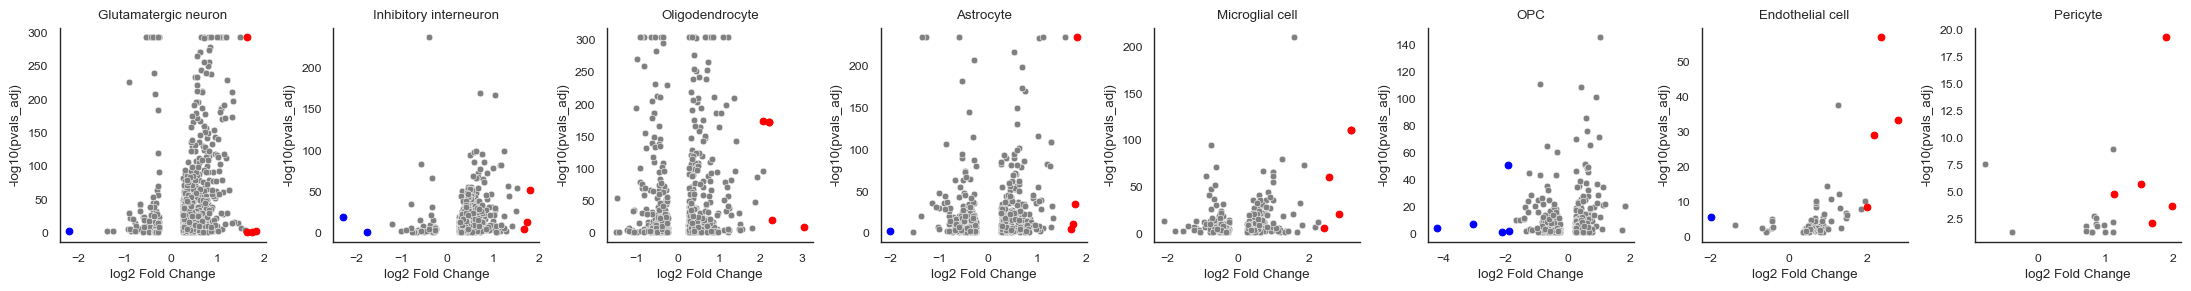

In [686]:
sns.set_context("paper")
sns.set_style("white")

fig, axes = plt.subplots(1, 8, figsize=(22,3))
axes = axes.flatten()

for i, cell_type in enumerate(cell_types):
    file_path = f"CellXGene/cross-dementia/filtered/data/degs_{cell_type}_mapped.csv"  # Ajustar el nombre del archivo según el formato

    try:
        # Cargar los datos
        df = pd.read_csv(file_path)

        df["-log10(pvals_adj)"] = -np.log10(df["pvals_adj"])

        # Obtener el menor pvals_adj no nulo y mayor a 0 para recalcular en caso de infinito
        min_pvals_adj = df.loc[df["pvals_adj"] > 0, "pvals_adj"].min() * 0.1

        # Calcular los valores corregidos en caso de infinito
        df.loc[np.isinf(df["-log10(pvals_adj)"]), "-log10(pvals_adj)"] = -np.log10(min_pvals_adj)

        top_genes = df.loc[df["logfoldchanges"].abs().nlargest(5).index]

        top_genes.loc[top_genes.index, "color"] = top_genes.loc[top_genes.index, "logfoldchanges"].apply(
            lambda x: "red" if x > 0 else "blue"
        )

        print(cell_type, ":", set(top_genes["gene_symbol"]))

        sns.scatterplot(data=df, y="-log10(pvals_adj)", x="logfoldchanges", color='grey', legend=False, ax=axes[i])

        # sns.scatterplot(data=top_genes, y="-log10(pvals_adj)", x="logfoldchanges", hue='color', legend=False, ax=axes[i])
        # texts = []
        for _, row in top_genes.iterrows():
            axes[i].scatter(row["logfoldchanges"], row["-log10(pvals_adj)"], color=row['color'])
        #     axes[i].text(row["logfoldchanges"] + 0.15, row["-log10(pvals_adj)"] + 0.25, row["gene_symbol"], fontsize=5, color="black")
        #
        # adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

        axes[i].set_ylabel("-log10(pvals_adj)")
        axes[i].set_xlabel("log2 Fold Change")
        axes[i].set_title(f"{titles[i]}")

    except FileNotFoundError:
        axes[i].set_title(f"No data for {cell_type}")
        axes[i].axis("off")

plt.tight_layout()
sns.despine()
# plt.savefig('CellXGene/cross-dementia/plots/volcano_per_type_notext.svg', format = 'svg', dpi=1200)
plt.show()

In [687]:
top_genes_info = {'glutamatergic neuron': ['C1QA', 'HSPB1', 'GPR6', 'DRD4', 'CD14'], 'inhibitory neuron': ['PENK', 'GPR6', 'CRYZ', 'ARAP3', 'DRD4'], 'oligodendrocyte': ['RELN', 'CXCR4', 'BIRC3', 'HSPA1B'], 'astrocyte': ['CRYAB', 'ANXA1', 'EGR1', 'EGF', 'S100A10'], 'microglial cell': ['BAG3', 'HSPA1B', 'HSPB1', 'DNAJB1'], 'oligodendrocyte precursor cell': ['FOS', 'IGFBP3', 'EGR1', 'SOCS3', 'VGF'], 'endothelial cell of vascular tree': ['HSPA1B', 'CACYBP', 'RBM3', 'HSPB1', 'HSPH1'], 'pericyte': ['HSPA1B', 'CRYAB', 'HSPB1', 'VIM', 'HSPH1']}

In [531]:
for i, cell_type in enumerate(cell_types):
    file_path = f"CellXGene/cross-dementia/filtered/graphs/gephi/degs_{cell_type}_mapped_gephi.csv"  # Ajustar el nombre del archivo según el formato

    try:
        # Cargar los datos
        df = pd.read_csv(file_path)

        df["-log10(pvals_adj)"] = -np.log10(df["pvals_adj"])

        top_genes = df.loc[df["logfoldchanges"].abs().nlargest(5).index]

        # Crear la columna "flag" con False por defecto
        df["flag"] = False

        # Marcar los top 5 genes como True
        df.loc[top_genes.index, "flag"] = True
        print(df)
        df.to_csv(f"CellXGene/cross-dementia/filtered/graphs/gephi/degs_{cell_type}_mapped_gephi.csv", index=False)
        # print(f"Archivo guardado: {output_file}")

    except FileNotFoundError:
        print(f"No data for {cell_type}")


         Id   gene_id gene_symbol            names  logfoldchanges  \
0    Q9Y276     617.0       BCS1L  ENSG00000074582        0.837833   
1    P11169    6515.0      SLC2A3  ENSG00000059804        0.387271   
2    Q12904    9255.0       AIMP1  ENSG00000164022        0.431453   
3    Q8N165  149420.0      PDIK1L  ENSG00000175087        0.293635   
4    P67809    4904.0        YBX1  ENSG00000065978        0.364904   
..      ...       ...         ...              ...             ...   
728  Q9NQ75   57091.0       CASS4  ENSG00000087589        0.861684   
729  Q92520   10447.0       FAM3C  ENSG00000196937        0.350469   
730  Q08117     166.0        TLE5  ENSG00000104964        0.452040   
731  P35638    1649.0       DDIT3  ENSG00000175197        0.872030   
732  O15121    8560.0       DEGS1  ENSG00000143753        0.813354   

             pvals     pvals_adj     scores  -log10(pvals_adj)   flag  
0     5.074668e-04  1.902495e-03   3.476784           2.720677  False  
1     1.823817e

C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\Andrea\Downloads\single-cell\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


    protein_id   gene_id gene_symbol            names  logfoldchanges  \
0       Q9Y276     617.0       BCS1L  ENSG00000074582        0.837833   
1       P11169    6515.0      SLC2A3  ENSG00000059804        0.387271   
2       Q12904    9255.0       AIMP1  ENSG00000164022        0.431453   
3       Q8N165  149420.0      PDIK1L  ENSG00000175087        0.293635   
4       P67809    4904.0        YBX1  ENSG00000065978        0.364904   
..         ...       ...         ...              ...             ...   
728     Q9NQ75   57091.0       CASS4  ENSG00000087589        0.861684   
729     Q92520   10447.0       FAM3C  ENSG00000196937        0.350469   
730     Q08117     166.0        TLE5  ENSG00000104964        0.452040   
731     P35638    1649.0       DDIT3  ENSG00000175197        0.872030   
732     O15121    8560.0       DEGS1  ENSG00000143753        0.813354   

             pvals     pvals_adj     scores  -log10(pvals_adj) color  
0     5.074668e-04  1.902495e-03   3.476784         

AttributeError: PathCollection.set() got an unexpected keyword argument 'order'

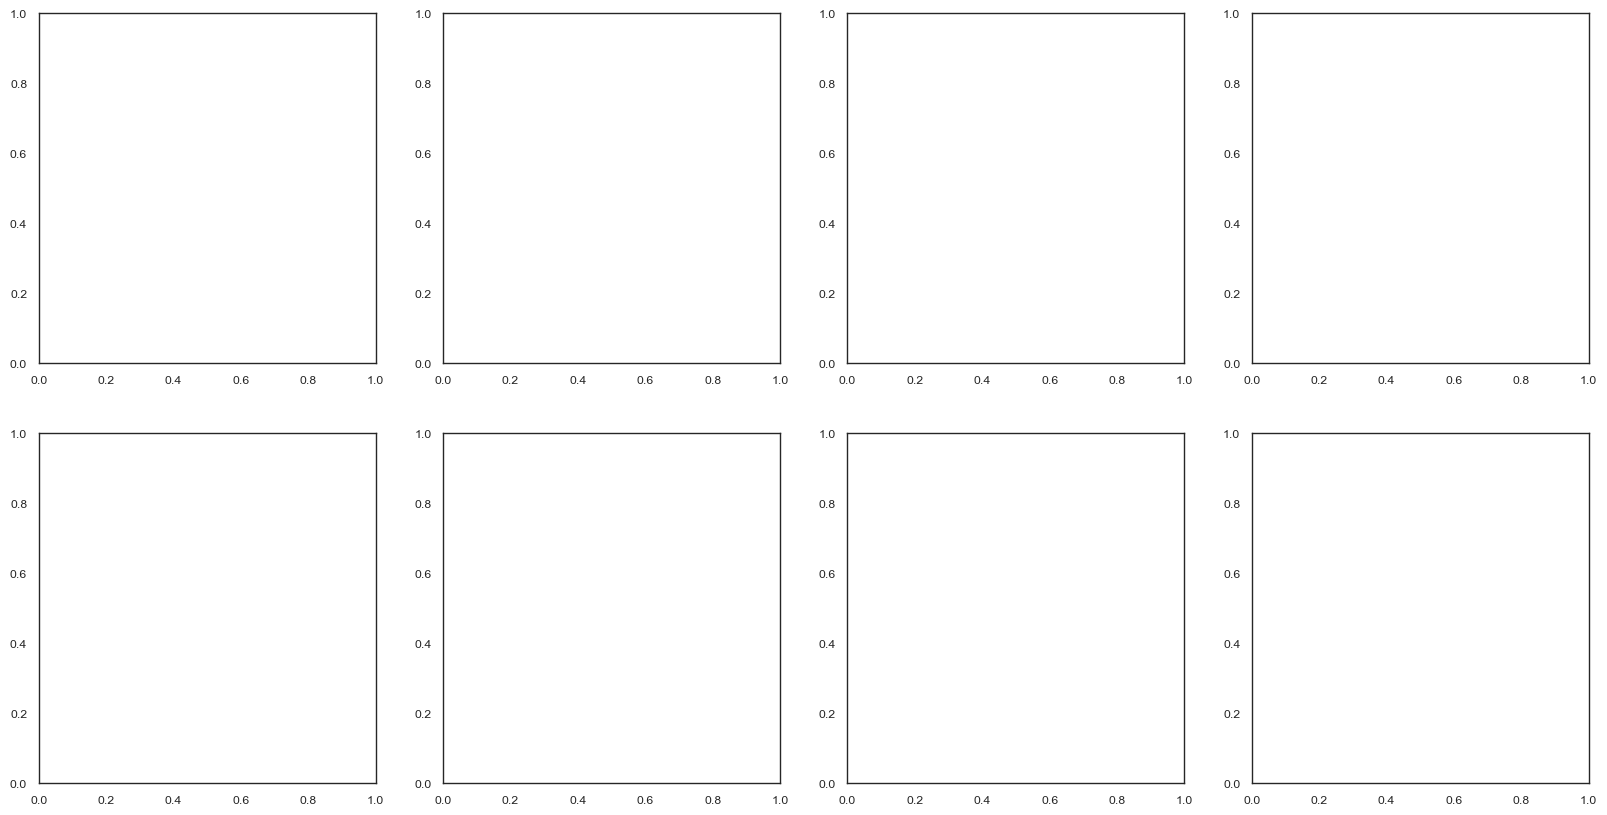

In [480]:
sns.set_context("paper")
sns.set_style("white")

fig, axes = plt.subplots(2, 4, figsize=(20,10))
# fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.flatten()

order = ['glutamatergic neuron', 'inhibitory interneuron',
         'oligodendrocyte', 'astrocyte', 'microglial cell',
         'oligodendrocyte precursor cell', 'endothelial cell of vascular tree', 'pericyte']

# Iterar sobre cada tipo celular y graficar su volcano plot
for i, cell_type in enumerate(order):
    file_path = f"CellXGene/cross-dementia/filtered/data/degs_{cell_type}_mapped.csv"  # Ajustar el nombre del archivo según el formato

    try:
        # Cargar los datos
        df = pd.read_csv(file_path)

        # Calcular el eje x: -log10(pvals_adj)
        df["-log10(pvals_adj)"] = -np.log10(df["pvals_adj"])

        df["color"] = "grey"  # Color predeterminado para genes no significativos
        top_genes = df.loc[df["logfoldchanges"].abs().nlargest(5).index]

        # Asignar el color según el signo de logfoldchanges
        df.loc[top_genes.index, "color"] = df.loc[top_genes.index, "logfoldchanges"].apply(
            lambda x: "red" if x > 0 else "blue"
        )
        print(df)

        sns.scatterplot(data=df, y="-log10(pvals_adj)", x="logfoldchanges", legend=False, ax=axes[i])

        # for _, row in top_genes.iterrows():
        #     # axes[i].scatter(row["logfoldchanges"], row["-log10(pvals_adj)"])
        #     axes[i].text(row["logfoldchanges"] + 0.05, row["-log10(pvals_adj)"] + 0.1, row["gene_symbol"], fontsize=5, color="black")

        # Etiquetas y título
        axes[i].set_ylabel("-log10(pvals_adj)")
        axes[i].set_xlabel("log2 Fold Change")
        axes[i].set_title(f"{cell_type}")
        # axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
        # axes[i].grid(True, linestyle='--', alpha=0.7)
    except FileNotFoundError:
        axes[i].set_title(f"No data for {cell_type}")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
sns.despine()
# plt.savefig('CellXGene/cross-dementia/plots/volcano_per_type.svg', format = 'svg', dpi=1200)
# plt.savefig('CellXGene/cross-dementia/plots/volcano_per_type.png', format = 'png', dpi=500)
plt.show()


### 6.4. Representation of top 20 most up- and down-regulated differentially expressed genes

In [276]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [ ]:
file_pattern = 'CellXGene/cross-dementia/filtered/data/degs_*_mapped.csv'
files = glob.glob(file_pattern)

In [281]:
dfs = []

# Leer cada archivo y seleccionar las columnas relevantes
for file in files:
    df = pd.read_csv(file)

    df_filtered = df[['protein_id', 'gene_symbol', 'logfoldchanges']]

    cell_type = file.split('/')[-1].split('_')[1]
    df_filtered['cell_type'] = cell_type
    # Añadir el DataFrame a la lista
    dfs.append(df_filtered)

# Concatenar todos los DataFrames en uno solo
lfc_df = pd.concat(dfs, ignore_index=True)
print(lfc_df)

     protein_id gene_symbol  logfoldchanges  cell_type
0        P04626       ERBB2       -0.287940  astrocyte
1        Q8TCT8      SPPL2A       -0.353458  astrocyte
2        Q14517        FAT1        0.343325  astrocyte
3        O60290      ZNF862        0.419059  astrocyte
4        P35613         BSG       -0.386828  astrocyte
...         ...         ...             ...        ...
3234     Q15185      PTGES3        0.866479   pericyte
3235     P08670         VIM        1.117781   pericyte
3236     Q7Z6G8      ANKS1B        0.978241   pericyte
3237     Q09666       AHNAK        0.989039   pericyte
3238     P49716       CEBPD        0.708934   pericyte

[3239 rows x 4 columns]


C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\72016613.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cell_type'] = cell_type
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\72016613.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cell_type'] = cell_type
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\72016613.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [436]:
top_high = lfc_df.nlargest(20, "logfoldchanges")["protein_id"]
top_low = lfc_df.nsmallest(20, "logfoldchanges")["protein_id"]
top_proteins = pd.concat([top_high, top_low])

In [437]:
lfc_filtered = lfc_df[lfc_df["protein_id"].isin(top_proteins)]

In [286]:
heatmap_df = lfc_filtered.pivot(index="protein_id", columns="cell_type", values="logfoldchanges")

# Agregar anotación de gene_symbol en las filas
gene_symbols = lfc_filtered.set_index("protein_id")["gene_symbol"].to_dict()
heatmap_df.index = heatmap_df.index.map(lambda x: f"{gene_symbols.get(x, x)} ({x})")  # Formato: gene_symbol (protein_id)

heatmap_df["max_lfc"] = heatmap_df.max(axis=1)  # Calcular la media de logfoldchange por proteína
heatmap_df = heatmap_df.sort_values(by="max_lfc", ascending=False)  # Ordenar de mayor a menor
heatmap_df = heatmap_df.drop(columns=["max_lfc"])  # Eliminar la columna auxiliar

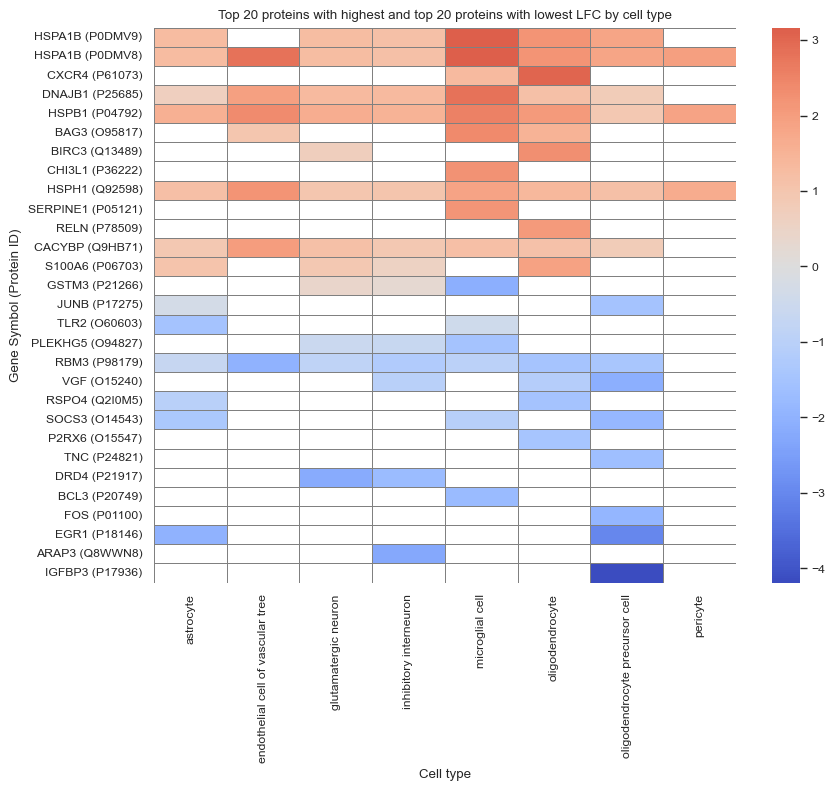

In [287]:
sns.set_context("paper")
sns.set_style("white")

# Crear heatmap
plt.figure(figsize=(9, 8))
sns.heatmap(heatmap_df, cmap="coolwarm", center=0, linewidths=0.5, annot=False, linecolor='grey')
plt.title("Top 20 proteins with highest and top 20 proteins with lowest LFC by cell type")
plt.xlabel("Cell type")
plt.ylabel("Gene Symbol (Protein ID)")
# plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig('CellXGene/cross-dementia/plots/heatmap_top20genes.svg', format = 'svg', dpi=1200)
plt.show()

### 6.5. Representation of differentially expressed genes expressed in all cell types

In [60]:
gen_pro = pd.read_csv('CellXGene/gen_pro.tsv', sep='\t')
gen = pd.read_csv("CellXGene/gen.tsv", sep="\t")

In [61]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

cell_networks = {cell: nx.read_graphml(f"CellXGene/cross-dementia/filtered/graphs/{cell}_network.graphml") for cell in cell_types}
cell_networks

{'astrocyte': <networkx.classes.graph.Graph at 0x2bbb14d2460>,
 'microglial cell': <networkx.classes.graph.Graph at 0x2bba59f9190>,
 'oligodendrocyte': <networkx.classes.graph.Graph at 0x2bba59f93a0>,
 'glutamatergic neuron': <networkx.classes.graph.Graph at 0x2bba59f9550>,
 'inhibitory interneuron': <networkx.classes.graph.Graph at 0x2bba59f95e0>,
 'endothelial cell of vascular tree': <networkx.classes.graph.Graph at 0x2bba59f9340>,
 'oligodendrocyte precursor cell': <networkx.classes.graph.Graph at 0x2bba59f9670>,
 'pericyte': <networkx.classes.graph.Graph at 0x2bba59f91f0>}

In [62]:
combined_degs = [
    {"protein_id": node, "gene_symbol": G.nodes[node]['gene_symbol'], "gene_id": G.nodes[node]['gene_id'], "cell_type": cell_type, "logfoldchanges": G.nodes[node]['logfoldchanges']}
    for cell_type, G in cell_networks.items()
    for node in G.nodes()
    if "logfoldchanges" in G.nodes[node]
]

In [69]:
df = pd.DataFrame(combined_degs)

protein_id gene_symbol   gene_id  cell_type  logfoldchanges
0        P04626       ERBB2    2064.0  astrocyte       -0.287940
1        Q14517        FAT1    2195.0  astrocyte        0.343325
2        Q8TCT8      SPPL2A   84888.0  astrocyte       -0.353458
3        O60290      ZNF862  643641.0  astrocyte        0.419059
4        P35613         BSG     682.0  astrocyte       -0.386828
...         ...         ...       ...        ...             ...
3234     P60484        PTEN    5728.0   pericyte       -0.782102
3235     P17676       CEBPB    1051.0   pericyte        1.105564
3236     P49716       CEBPD    1052.0   pericyte        0.708934
3237     Q09666       AHNAK   79026.0   pericyte        0.989039
3238     Q7Z6G8      ANKS1B   56899.0   pericyte        0.978241

[3239 rows x 5 columns]

In [74]:
count_cells = df.groupby("protein_id")["cell_type"].nunique().reset_index()
count_cells.columns = ["protein_id", "num_cell_types"]

df2 = df.merge(count_cells, on="protein_id")
df2

protein_id gene_symbol   gene_id  cell_type  logfoldchanges  \
0        P04626       ERBB2    2064.0  astrocyte       -0.287940   
1        Q14517        FAT1    2195.0  astrocyte        0.343325   
2        Q8TCT8      SPPL2A   84888.0  astrocyte       -0.353458   
3        O60290      ZNF862  643641.0  astrocyte        0.419059   
4        P35613         BSG     682.0  astrocyte       -0.386828   
...         ...         ...       ...        ...             ...   
3234     P60484        PTEN    5728.0   pericyte       -0.782102   
3235     P17676       CEBPB    1051.0   pericyte        1.105564   
3236     P49716       CEBPD    1052.0   pericyte        0.708934   
3237     Q09666       AHNAK   79026.0   pericyte        0.989039   
3238     Q7Z6G8      ANKS1B   56899.0   pericyte        0.978241   

      num_cell_types  
0                  1  
1                  2  
2                  1  
3                  4  
4                  3  
...              ...  
3234               2  
3235               4  
3236               5  
3237               3  
3238               4  

[3239 rows x 6 columns]

In [73]:
df2['num_cell_types'].value_counts()

num_cell_types
2    932
3    690
1    610
4    500
5    240
6    114
7    105
8     48
Name: count, dtype: int64

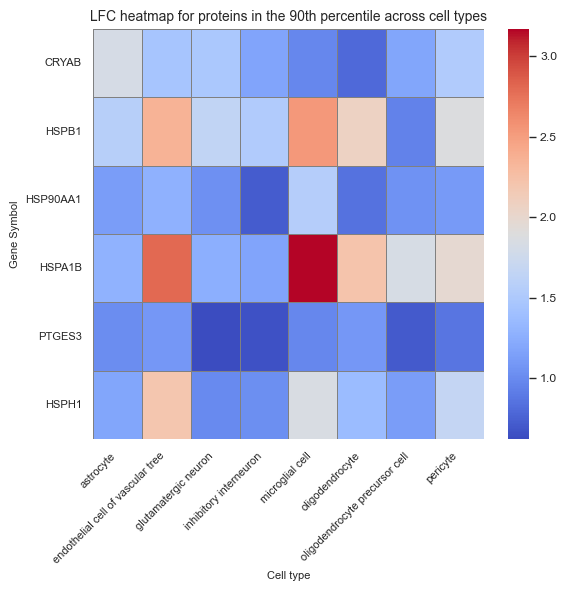

In [75]:
# Heatmap con valores de expresión agrupados por proteinas y anotación por el gen que codifica dicha proteína.

df_filtered_proteins = df2[df2["num_cell_types"] == 8]

# Crear un diccionario de mapeo de protein_id a gene_symbol
gene_symbol_mapping = df_filtered_proteins.set_index("protein_id")["gene_symbol"].drop_duplicates()

# Crear la tabla pivote
df_pivot = df_filtered_proteins.pivot_table(index="protein_id", columns="cell_type", values="logfoldchanges")

sns.set_context("paper")
sns.set_style("white")

# Crear la figura y el heatmap
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_pivot, cmap="coolwarm", linewidths=0.5, fmt=".2f", linecolor='grey', cbar=True, square=False, ax=ax)

# Ajustar título y etiquetas
title = "LFC heatmap for proteins in the 90th percentile across cell types"
plt.title(title, fontsize=10)
plt.xlabel("Cell type", fontsize=8)
plt.ylabel("Gene Symbol", fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(gene_symbol_mapping.loc[df_pivot.index].values, rotation=0, fontsize=8)
plt.tight_layout()

# plt.savefig('CellXGene/cross-dementia/plots/commonproteins.svg', format = 'svg', dpi=1200)
plt.show()

#### Combination of 6.4 and 6.5 plots

In [445]:
##  HEATMAP 1: Top 20 más ↑ y ↓ logfoldchange

top_high = lfc_df.sort_values(by="logfoldchanges", ascending=False)["protein_id"].drop_duplicates().head(20)
top_low = lfc_df.sort_values(by="logfoldchanges", ascending=True)["protein_id"].drop_duplicates().head(20)
top_proteins = pd.concat([top_high, top_low])

lfc_filtered = lfc_df[lfc_df["protein_id"].isin(top_proteins)]

lfc_filtered["max_abs_LFC"] = lfc_filtered["logfoldchanges"].abs()
lfc_filtered['cell_type'] = lfc_filtered["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")
lfc_filtered

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\1253390478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfc_filtered["max_abs_LFC"] = lfc_filtered["logfoldchanges"].abs()
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\1253390478.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lfc_filtered['cell_type'] = lfc_filtered["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")


protein_id gene_symbol  logfoldchanges        cell_type  max_abs_LFC
14       P43490       NAMPT       -0.900505        astrocyte     0.900505
22       P06703      S100A6        1.067540        astrocyte     1.067540
50       Q2I0M5       RSPO4       -1.032063        astrocyte     1.032063
118      O60603        TLR2       -1.532612        astrocyte     1.532612
133      P17275        JUNB       -0.300338        astrocyte     0.300338
...         ...         ...             ...              ...          ...
3194     P04792       HSPB1        2.069515  oligodendrocyte     2.069515
3223     P04792       HSPB1        1.884719         pericyte     1.884719
3227     Q92598       HSPH1        1.676103         pericyte     1.676103
3230     P0DMV8      HSPA1B        1.975146         pericyte     1.975146
3232     P02511       CRYAB        1.525713         pericyte     1.525713

[123 rows x 5 columns]

In [448]:
## HEATMAP 2: Proteínas con expresión en 8 tipos celulares

cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron',
              'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

cell_networks = {cell: nx.read_graphml(f"CellXGene/cross-dementia/filtered/graphs/{cell}_network.graphml") for cell in
                 cell_types}
cell_networks
combined_degs = [
    {"protein_id": node, "gene_symbol": G.nodes[node]['gene_symbol'], "gene_id": G.nodes[node]['gene_id'],
     "cell_type": cell_type, "logfoldchanges": G.nodes[node]['logfoldchanges']}
    for cell_type, G in cell_networks.items()
    for node in G.nodes()
    if "logfoldchanges" in G.nodes[node]
]
df = pd.DataFrame(combined_degs)

count_cells = df.groupby("protein_id")["cell_type"].nunique().reset_index()
count_cells.columns = ["protein_id", "num_cell_types"]

df2 = df.merge(count_cells, on="protein_id")
df2['cell_type'] = df2["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")
df2

protein_id gene_symbol   gene_id  cell_type  logfoldchanges  \
0        P04626       ERBB2    2064.0  astrocyte       -0.287940   
1        Q14517        FAT1    2195.0  astrocyte        0.343325   
2        Q8TCT8      SPPL2A   84888.0  astrocyte       -0.353458   
3        O60290      ZNF862  643641.0  astrocyte        0.419059   
4        P35613         BSG     682.0  astrocyte       -0.386828   
...         ...         ...       ...        ...             ...   
3234     P60484        PTEN    5728.0   pericyte       -0.782102   
3235     P17676       CEBPB    1051.0   pericyte        1.105564   
3236     P49716       CEBPD    1052.0   pericyte        0.708934   
3237     Q09666       AHNAK   79026.0   pericyte        0.989039   
3238     Q7Z6G8      ANKS1B   56899.0   pericyte        0.978241   

      num_cell_types  
0                  1  
1                  2  
2                  1  
3                  4  
4                  3  
...              ...  
3234               2  
3235               4  
3236               5  
3237               3  
3238               4  

[3239 rows x 6 columns]

In [671]:
titles = ['Glutamatergic neuron', 'Inhibitory interneuron', 'Oligodendrocyte', 'Astrocyte', 'Microglial cell', 'OPC', 'Endothelial cell', 'Pericyte']

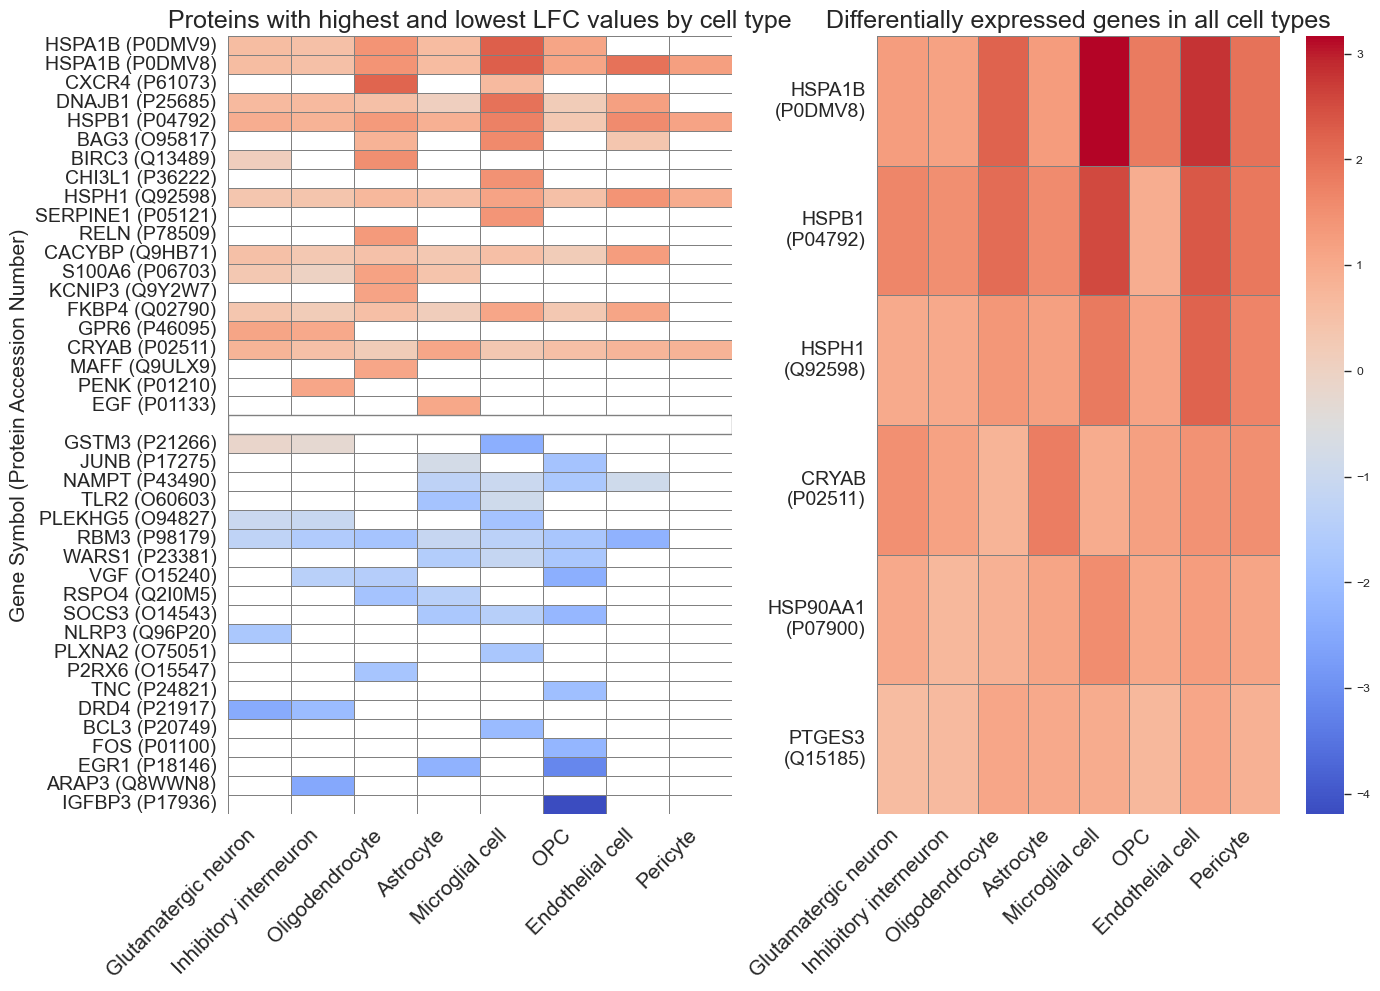

In [680]:
# 🔹
# top_high = lfc_df.sort_values(by="logfoldchanges", ascending=False)["protein_id"].drop_duplicates().head(20)
# top_low = lfc_df.sort_values(by="logfoldchanges", ascending=True)["protein_id"].drop_duplicates().head(20)
#
# top_proteins = pd.concat([top_high, top_low])
#
# lfc_filtered = lfc_df[lfc_df["protein_id"].isin(top_proteins)].copy()

# lfc_filtered = lfc_filtered["cell_type"].replace("endothelial cell of vascular tree", "endothelial cell")

heatmap_df = lfc_filtered.pivot(index="protein_id", columns="cell_type", values="logfoldchanges")

# Agregar anotación de gene_symbol
gene_symbols = lfc_filtered.set_index("protein_id")["gene_symbol"].to_dict()
heatmap_df.index = [f"{gene_symbols.get(x, x)} ({x})" for x in heatmap_df.index]

heatmap_df["max_lfc"] = heatmap_df.max(axis=1)
heatmap_df = heatmap_df.sort_values(by="max_lfc", ascending=False).drop(columns=["max_lfc"])

# 🔹 Espacio en blanco entre los genes más up y down regulados
half = len(heatmap_df) // 2
gap = pd.DataFrame(np.nan, index=[""], columns=heatmap_df.columns)  # Dos filas vacías como separador
heatmap_df = pd.concat([heatmap_df.iloc[:half], gap, heatmap_df.iloc[half:]])

# 🔹 HEATMAP 2: Proteínas con expresión en 8 tipos celulares
df_filtered_proteins = df2[df2["num_cell_types"] == 8]
gene_symbol_mapping = df_filtered_proteins.set_index("protein_id")["gene_symbol"].drop_duplicates()
df_pivot = df_filtered_proteins.pivot_table(index="protein_id", columns="cell_type", values="logfoldchanges")

# Agregar anotación de gene_symbol
# df_pivot.index = [f"{gene_symbol_mapping.get(x, x)} ({x})" for x in df_pivot.index]
# Agregar anotación de gene_symbol con salto de línea
df_pivot.index = [f"{gene_symbol_mapping.get(x, x)}\n({x})" for x in df_pivot.index]

df_pivot["max_lfc"] = df_pivot.max(axis=1)
df_pivot = df_pivot.sort_values(by="max_lfc", ascending=False).drop(columns=["max_lfc"])

# Definir el orden deseado de las columnas
order = ['glutamatergic neuron', 'inhibitory interneuron',
         'oligodendrocyte', 'astrocyte', 'microglial cell',
         'oligodendrocyte precursor cell', 'endothelial cell', 'pericyte']

# Reordenar las columnas de los DataFrame antes de graficar
heatmap_df = heatmap_df[order]
df_pivot = df_pivot[order]

# 🔹 Definir escala de colores compartida
vmin = min(heatmap_df.min().min(), df_pivot.min().min())
vmax = max(heatmap_df.max().max(), df_pivot.max().max())

# 🔹 Configurar estilo y figura con 2 subplots
sns.set_context("paper")
sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(14, 10), gridspec_kw={'width_ratios': [1, 1]})

# Heatmap 1: Top 20 ↑↓ logfoldchange
sns.heatmap(
    heatmap_df, cmap="coolwarm", center=0, linewidths=0.5, linecolor="grey",
    vmin=vmin, vmax=vmax, annot=False, ax=axes[0], cbar=False
)
axes[0].add_patch(Rectangle((0, 20), 8, 1, fill=True, facecolor= 'white', edgecolor='gray', lw=1))
axes[0].set_title("Proteins with highest and lowest LFC values by cell type", fontsize=18)
axes[0].set_xlabel("")
axes[0].set_ylabel("Gene Symbol (Protein Accession Number)", fontsize=15)
axes[0].set_xticklabels(titles, rotation=45, ha='right', fontsize=15)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=14)

# Heatmap 2: High variability proteins
sns.heatmap(
    df_pivot, cmap="coolwarm", linewidths=0.5, linecolor='grey',
    vmin=vmin, vmax=vmax, annot=False, ax=axes[1]
)
axes[1].set_title("Differentially expressed genes in all cell types", fontsize=18)
axes[1].set_xlabel("")
axes[1].set_ylabel("")  # Evita duplicar etiqueta
axes[1].set_xticklabels(titles, rotation=45, ha='right', fontsize=15)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation = 0, fontsize=14)

# Ajustar distribución y guardar
plt.tight_layout()
plt.savefig('CellXGene/cross-dementia/plots/combined_heatmaps.pdf', format='pdf', dpi=1200)
# plt.savefig('CellXGene/cross-dementia/plots/combined_heatmaps_pdf.svg', format='svg', dpi=1200)
plt.show()


## 8. Network metrics analysis

Calculation of degrees, betweenness and closeness centralities and clustering coefficient for each of the cell type-specific DEGs inside the main interactome.

Considering the entire PPI, I want to know how the cell type-specific DEGs are located within the interactome. For the DEGs in each cell type, I draw the metrics (from the subnetworks I only need the genes that are in them) and plot the distributions that follow these metrics, comparing them with the distribution that the Alzheimer's module follows.

### 8.1. Alzheimer module calculation

In [ ]:
dis_gen = pd.read_csv('CellXGene/dis_gen.tsv', sep='\t')
gen_pro = pd.read_csv('CellXGene/gen_pro.tsv', sep='\t')
pro_pro = pd.read_csv('CellXGene/pro_pro.tsv', sep='\t')

In [ ]:
G_ppi = nx.from_pandas_edgelist(pro_pro, 'prA', 'prB')

In [ ]:
def get_disease_module(disease, dis_gen, gen_pro, pro_pro, PPI):
    genes = functions_proximity.genes_dis(disease, dis_gen)
    prots = functions_proximity.pro_gen_dict(genes, gen_pro)
    prots_interactome = functions_proximity.gen_pro_PPI(prots, pro_pro)
    SG = PPI.subgraph(prots_interactome)
    lcc = functions_proximity.lcc(SG)

    return lcc

In [ ]:
lcc_alz = get_disease_module('C0002395', dis_gen, gen_pro, pro_pro, G_ppi)
len(lcc_alz)

### 8.2. Metrics calculation for all the nodes in the interactome

In [605]:
def calculate_metrics(graph):
    """
    Calcula métricas de red a nivel de nodo. Devuelve un DataFrame con las métricas.
    """
    # Betweenness centrality
    betweenness = nx.betweenness_centrality(graph)

    # Closeness centrality
    closeness = nx.closeness_centrality(graph)

    # Clustering coefficient
    clustering = nx.clustering(graph)

    # Identificar hubs (proteínas con mayor grado)
    degree = dict(graph.degree())
    degree_values = list(degree.values())
    percentile_90 = np.percentile(degree_values, 90)
    is_hub = {node: degree[node] >= percentile_90 for node in degree}

    return betweenness, closeness, clustering, degree, is_hub

In [ ]:
# Calculo de las metricas de red para cada una de las proteinas de la PPI
betweenness, closeness, clustering, degree, is_hub = calculate_metrics(G_ppi)

In [ ]:
# Convert metrics of whole interactome to a dataframe
df = pd.DataFrame({
    'protein_id': list(degree.keys()),
    'degree': list(degree.values()),
    'betweenness_centrality': list(betweenness.values()),
    'closeness_centrality': list(closeness.values()),
    'is_hub': list(is_hub.values())
})

In [ ]:
df['is_in_LCC'] = df['protein_id'].isin(lcc_alz)

In [ ]:
df.to_csv('CellXGene/cross-dementia/filtered/results/G_ppi_analysis.csv', index = False)

### 8.3. Metrics calculation for the DEGs nodes for each cell type

In [ ]:
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron', 'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [ ]:
results_list = []

for cell_type in tqdm(cell_types, desc="Processing cell types..."):

    graph = nx.read_graphml(f'CellXGene/cross-dementia/filtered/graphs/{cell_type}_network.graphml')

    ppi_proteins = set(graph.nodes())
    print(ppi_proteins)

    # Añadir las métricas al DataFrame
    for protein in ppi_proteins:
        protein_id = protein
        gene_id = graph.nodes[protein].get("gene_id", "NA")
        gene_symbol = graph.nodes[protein].get("gene_symbol", "NA")
        logfoldchanges = graph.nodes[protein].get("logfoldchanges", "NA")
        pvals = graph.nodes[protein].get("pval", "NA")
        pvals_adj = graph.nodes[protein].get("pval_adj", "NA")

        # Obtener las métricas para la proteína
        betweenness_val = betweenness.get(protein_id, None)
        closeness_val = closeness.get(protein_id, None)
        clustering_val = clustering.get(protein_id, None)
        degree_val = degree.get(protein_id, None)
        is_hub_val = is_hub.get(protein_id, False)

        # Añadir la fila al DataFrame de resultados
        result_row = {
            "protein_id": protein_id,
            "gene_id": gene_id,
            "gene_symbol": gene_symbol,
            "cell_type": cell_type,
            "logfoldchanges": logfoldchanges,
            "pvals": pvals,
            "pvals_adj": pvals_adj,
            "degree": degree_val,
            "betweenness_centrality": betweenness_val,
            "closeness_centrality": closeness_val,
            "clustering_coefficient": clustering_val,
            "is_hub": is_hub_val
        }

        results_list.append(result_row)

results_df = pd.DataFrame(results_list)

results_df.to_csv('CellXGene/cross-dementia/filtered/results/network_analysis.csv', index=False)

### 8.4. Analysis of the metrics distributions across cell types

In [386]:
cell_data = pd.read_csv('CellXGene/cross-dementia/filtered/results/network_analysis.csv')
module_data = pd.read_csv('CellXGene/cross-dementia/filtered/results/G_ppi_analysis.csv')

module_data_lcc = module_data[module_data['is_in_LCC'] == True]

In [575]:
module_data_lcc["dataset"] = "General module for AD"
cell_data["dataset"] = cell_data["cell_type"]

# Reemplazar el nombre de "endothelial cell of vascular tree" por "endothelial cell"
combined_data = pd.concat([module_data_lcc, cell_data])
# combined_data["dataset"] = combined_data["dataset"].replace("endothelial cell of vascular tree", "Endothelial cell")
# combined_data["dataset"] = combined_data["dataset"].replace("oligodendrocyte precursor cell", "OPC")
# combined_data["dataset"] = combined_data["dataset"].replace("astrocyte", "Astrocyte")
combined_data

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\602881201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  module_data_lcc["dataset"] = "General module for AD"


protein_id  degree  betweenness_centrality  closeness_centrality  \
0     A0A087WXM9       8                0.000003              0.305735   
2         P05783      91                0.000429              0.367223   
4         P08670     266                0.003726              0.398942   
6         P53350     221                0.001902              0.381054   
32        Q96CV9      92                0.000621              0.362136   
...          ...     ...                     ...                   ...   
3234      P17676      27                0.000056              0.346096   
3235      P07900     237                0.001698              0.398471   
3236      P13693     124                0.000313              0.374662   
3237      P0DMV8      63                0.000533              0.359315   
3238      P08238     553                0.013363              0.420794   

      is_hub is_in_LCC                dataset  gene_id gene_symbol cell_type  \
0      False      True  General module for AD      NaN         NaN       NaN   
2       True      True  General module for AD      NaN         NaN       NaN   
4       True      True  General module for AD      NaN         NaN       NaN   
6       True      True  General module for AD      NaN         NaN       NaN   
32      True      True  General module for AD      NaN         NaN       NaN   
...      ...       ...                    ...      ...         ...       ...   
3234   False       NaN               pericyte   1051.0       CEBPB  pericyte   
3235    True       NaN               pericyte   3320.0    HSP90AA1  pericyte   
3236    True       NaN               pericyte   7178.0        TPT1  pericyte   
3237   False       NaN               pericyte   3304.0      HSPA1B  pericyte   
3238    True       NaN               pericyte   3326.0    HSP90AB1  pericyte   

      logfoldchanges         pvals     pvals_adj  clustering_coefficient  
0                NaN           NaN           NaN                     NaN  
2                NaN           NaN           NaN                     NaN  
4                NaN           NaN           NaN                     NaN  
6                NaN           NaN           NaN                     NaN  
32               NaN           NaN           NaN                     NaN  
...              ...           ...           ...                     ...  
3234        1.105564  9.147368e-06  5.491340e-03                0.150000  
3235        1.110109  2.761193e-13  1.112958e-09                0.061975  
3236        0.802365  1.618387e-04  4.390652e-02                0.056517  
3237        1.975146  1.293792e-07  1.738302e-04                0.045059  
3238        0.861556  2.566908e-06  2.336300e-03                0.020023  

[5936 rows x 14 columns]

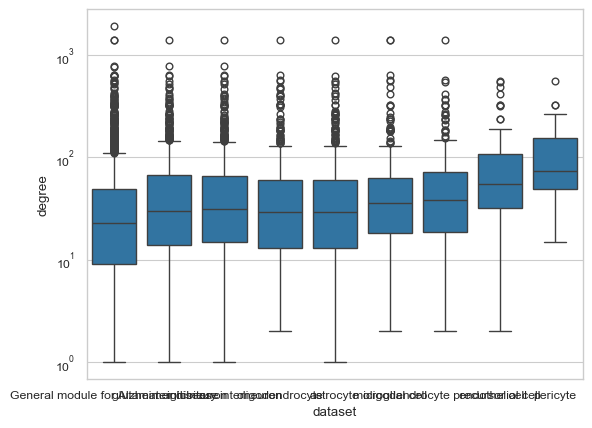

In [543]:
sns.boxplot(data=combined_data, x="dataset", y="degree")

plt.yscale('log')

In [655]:
titles = ['General module for AD', 'Glutamatergic neuron', 'Inhibitory interneuron', 'Oligodendrocyte', 'Astrocyte', 'Microglial cell', 'OPC', 'Endothelial cell', 'Pericyte']

In [656]:
max(10, len(ordered_datasets) * 0.5)

10

C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\2142562447.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset_sizes = combined_data.groupby("dataset")["protein_id"].nunique()
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\2142562447.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x="dataset", y="degree", ax=ax, palette=palette, order=ordered_datasets,dodge=False)
C:\Users\Andrea\AppData\Local\Temp\ipykernel_21772\2142562447.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{titles[i]}\nn = {subset_sizes

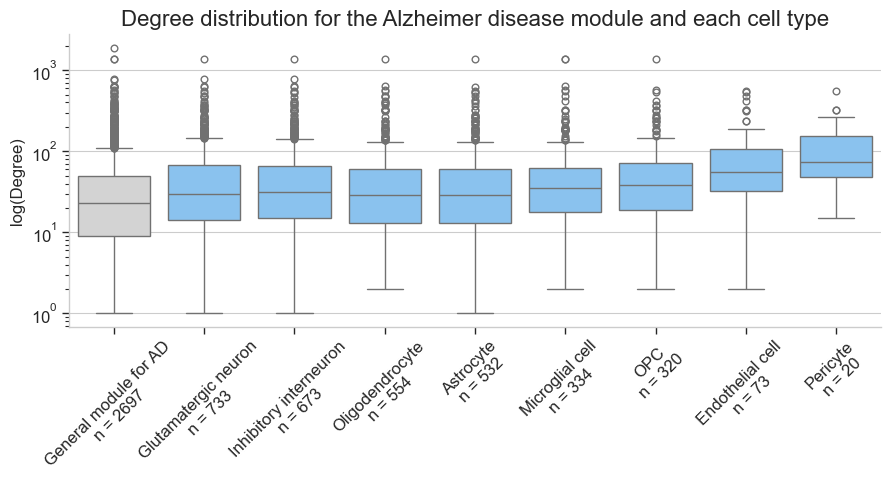

In [658]:
# Calcular el tamaño de cada subset
subset_sizes = combined_data.groupby("dataset")["protein_id"].nunique()

# Generar una paleta de colores
ordered_datasets = subset_sizes.sort_values(ascending=False).index
combined_data["dataset"] = pd.Categorical(combined_data["dataset"], categories=ordered_datasets, ordered=True)
palette = {dataset: '#79C4FF' for dataset in ordered_datasets}

# Asignar rojo al "Module"
palette["General module for AD"] = "#D3D3D3"

# fig, ax = plt.subplots(figsize=(max(10, len(ordered_datasets) * 0.5), 5))
fig, ax = plt.subplots(figsize=(9, 5))

sns.set_context("paper")
sns.set_style("whitegrid")

sns.boxplot(data=combined_data, x="dataset", y="degree", ax=ax, palette=palette, order=ordered_datasets,dodge=False)

ax.tick_params(axis='both', which='both', bottom=True, left=True)

plt.title('Degree distribution for the Alzheimer disease module and each cell type', fontsize=16)
plt.xlabel('')
# ax.set_xticklabels(titles, fontsize=9)
ax.set_xticklabels([f"{titles[i]}\nn = {subset_sizes[dataset]}" for i, dataset in enumerate(ordered_datasets)],
                   rotation=45, ha="center", fontsize=12)

# plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.ylabel('log(Degree)', fontsize=12)
sns.despine()
# Añadir leyenda y mostrar la gráfica
plt.tight_layout()
plt.savefig('CellXGene/cross-dementia/plots/degree_boxplot.pdf', format='pdf', dpi=1200)
# plt.savefig('CellXGene/cross-dementia/plots/degree_boxplot.svg', format='svg', dpi=1200)
plt.show()

In [595]:
fig, ax = plt.subplots(figsize=(13, 6))

sns.set_context("paper")
sns.set_style("whitegrid")

# Calcular el tamaño de cada subset
subset_sizes = combined_data.groupby("dataset")["protein_id"].nunique()

# Generar una paleta de colores
unique_datasets = combined_data["dataset"].unique()
palette = {dataset: '#79C4FF' for dataset in unique_datasets}

# Asignar rojo al "Module"
palette["Alzheimer LCC"] = "grey"
sns.violinplot(data=combined_data, x="dataset", y=np.log10(combined_data["degree"]), ax=ax, palette=palette)

# Añadir etiquetas con el tamaño de cada subset
for i, dataset in enumerate(combined_data["dataset"].unique()):
    ax.text(i, ax.get_ylim()[0], f"n = {subset_sizes.get(dataset, 0)}", ha='center', va='bottom', fontsize=10, color='black')

plt.title('Degree distribution for the Alzheimer disease module and each cell type')
plt.ylabel('log(Degree)')
plt.xlabel('Dataset / Cell type')

# Añadir leyenda y mostrar la gráfica
plt.tight_layout()
# plt.legend(title='Cell Types', loc='upper right')
plt.show()

AttributeError: Figure.set() got an unexpected keyword argument 'bottom'

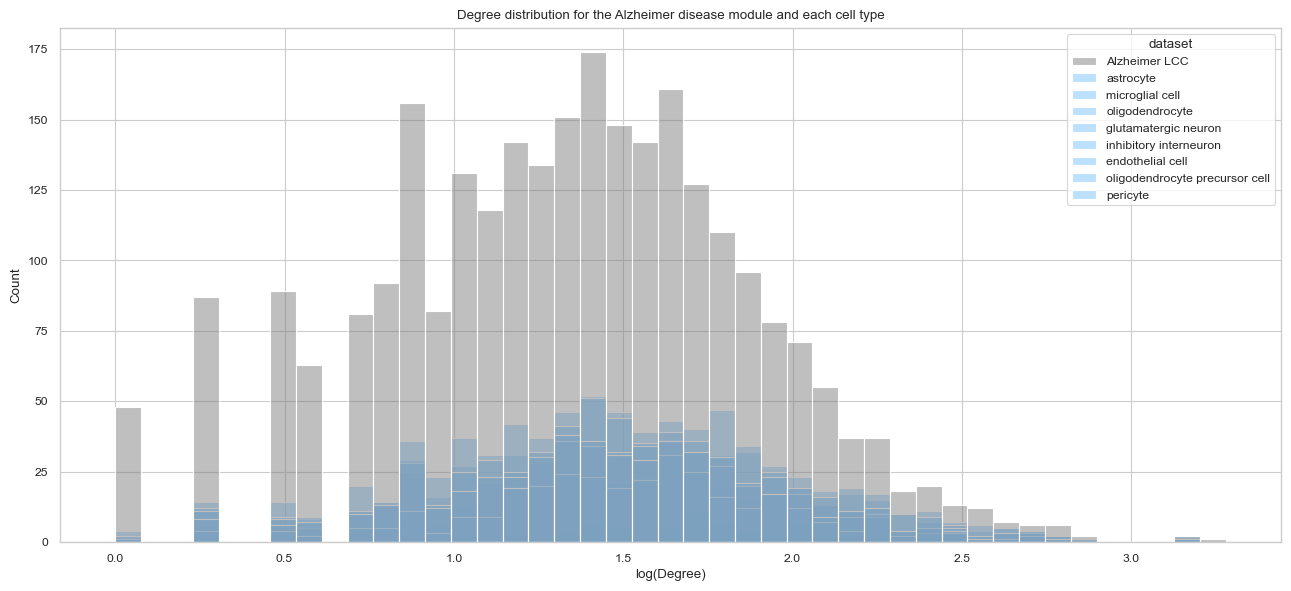

In [420]:
fig, ax = plt.subplots(figsize=(13, 6))

sns.set_context("paper")
sns.set_style("whitegrid")

# Calcular el tamaño de cada subset
subset_sizes = combined_data.groupby("dataset")["protein_id"].nunique()

# Generar una paleta de colores
unique_datasets = combined_data["dataset"].unique()
palette = {dataset: '#79C4FF' for dataset in unique_datasets}

# Asignar rojo al "Module"
palette["Alzheimer LCC"] = "grey"
sns.histplot(data=combined_data, x=np.log10(combined_data["degree"]), hue = 'dataset', ax=ax, palette=palette)

# Añadir etiquetas con el tamaño de cada subset
# for i, dataset in enumerate(combined_data["dataset"].unique()):
#     ax.text(i, ax.get_ylim()[0], f"n = {subset_sizes.get(dataset, 0)}", ha='center', va='bottom', fontsize=10, color='black')

plt.title('Degree distribution for the Alzheimer disease module and each cell type')
plt.xlabel('log(Degree)')
# plt.ylabel('log(Protein Count)')

# Añadir leyenda y mostrar la gráfica
plt.tight_layout()
# plt.legend(title='Cell Types', loc='upper right')
plt.show()

In [367]:
plot_data = cell_data.groupby(["degree", "cell_type"]).count()["protein_id"].reset_index()
plot_data.rename(columns={"protein_id": "protein_count"}, inplace=True)

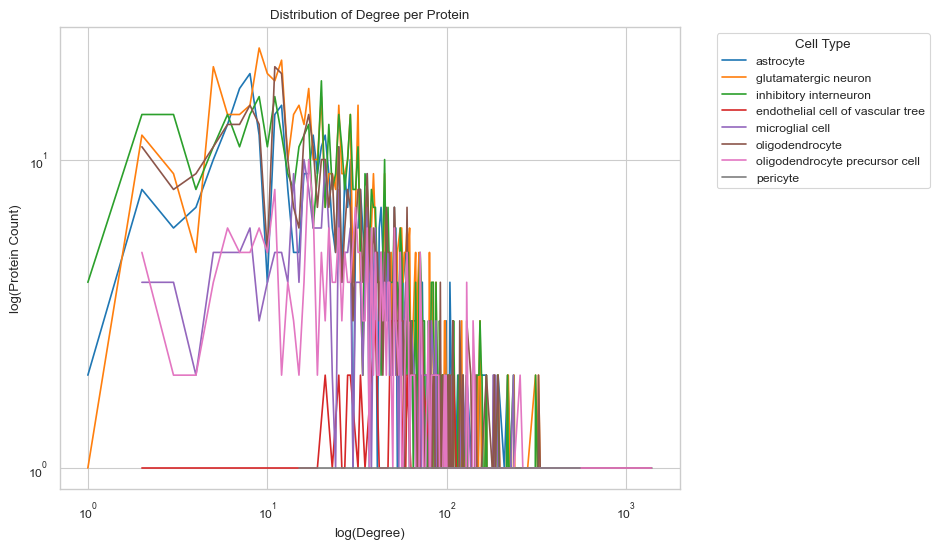

In [455]:


plt.figure(figsize=(8, 6))
# sns.barplot(data=plot_data, x="degree", y="protein_count", hue="cell_type", alpha=0.7)
sns.lineplot(data=plot_data, x="degree", y="protein_count", hue="cell_type")
# sns.boxplot(data = plot_data, x = "degree", y = "protein_count", hue = "cell_type")
# Configurar escala logarítmica en ambos ejes
plt.xscale("log")
plt.yscale("log")

# Etiquetas
plt.xlabel("log(Degree)")
plt.ylabel("log(Protein Count)")
plt.title("Distribution of Degree per Protein")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")

# Mostrar el gráfico
plt.show()

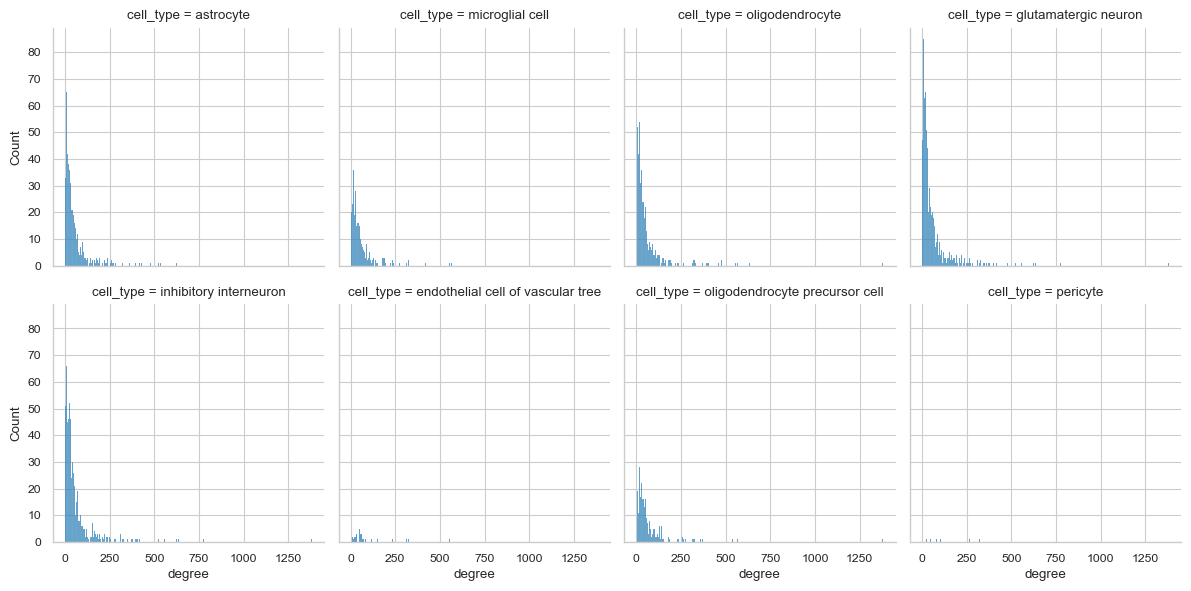

In [301]:
g = sns.FacetGrid(cell_data, col="cell_type", col_wrap=4, sharex=True, sharey=True)
g.map(sns.histplot, "degree", bins=300)
plt.show()

#### Numeric analysis


In [659]:
cell_data = pd.read_csv('CellXGene/cross-dementia/filtered/results/network_analysis.csv')

In [668]:
cols_of_interest = ["degree"]

# Calcular estadísticas por 'cell_type'
stats = cell_data.groupby("cell_type")["degree"].agg(["mean", "std", "median", "min", "max"])

stats["count"] = cell_data.groupby("cell_type").size()

# Mostrar resultados
print(stats)

# Si deseas guardar los resultados en un archivo CSV:
stats.to_csv("CellXGene/cross-dementia/filtered/results/cell_type_statistics.csv")

                                         mean         std  median  min   max  \
cell_type                                                                      
astrocyte                           57.486842   97.024051    29.0    1  1379   
endothelial cell of vascular tree   98.767123  119.863872    55.0    2   553   
glutamatergic neuron                61.219645   98.005476    30.0    1  1379   
inhibitory interneuron              61.210996   99.727546    31.0    1  1381   
microglial cell                     66.434132  129.637865    35.5    2  1381   
oligodendrocyte                     56.301444   97.276815    29.0    2  1379   
oligodendrocyte precursor cell      65.284375  105.131312    38.0    2  1379   
pericyte                           132.300000  138.173080    74.0   15   553   

                                   count  
cell_type                                 
astrocyte                            532  
endothelial cell of vascular tree     73  
glutamatergic neuron       

In [669]:
module_data = pd.read_csv('CellXGene/cross-dementia/filtered/results/G_ppi_analysis.csv')

module_data_lcc = module_data[module_data['is_in_LCC'] == True]

# Calcular estadísticas por 'cell_type'
stats = module_data_lcc["degree"].agg(["mean", "std", "median", "min", "max", "count"])

# stats["count"] = module_data_lcc.groupby("cell_type").size()

# Mostrar resultados
print(stats)

# Si deseas guardar los resultados en un archivo CSV:
# stats.to_csv("CellXGene/cross-dementia/filtered/results/general_module_statistics.csv")

mean        45.292918
std         84.963373
median      23.000000
min          1.000000
max       1901.000000
count     2697.000000
Name: degree, dtype: float64


In [704]:
gene_info = []

for type, gene in top_genes_info.items():
    for g in gene:
        gene_info.append(g)
        # gene_info = gene_info.append(cell_data[cell_data['gene_symbol'] == g])


# gene_info = pd.DataFrame(gene_info)
print(gene_info)

cell_data[cell_data['gene_symbol'].isin(gene_info)].to_csv('CellXGene/cross-dementia/filtered/results/top_gene_info.csv', index = False)

['C1QA', 'HSPB1', 'GPR6', 'DRD4', 'CD14', 'PENK', 'GPR6', 'CRYZ', 'ARAP3', 'DRD4', 'RELN', 'CXCR4', 'BIRC3', 'HSPA1B', 'CRYAB', 'ANXA1', 'EGR1', 'EGF', 'S100A10', 'BAG3', 'HSPA1B', 'HSPB1', 'DNAJB1', 'FOS', 'IGFBP3', 'EGR1', 'SOCS3', 'VGF', 'HSPA1B', 'CACYBP', 'RBM3', 'HSPB1', 'HSPH1', 'HSPA1B', 'CRYAB', 'HSPB1', 'VIM', 'HSPH1']


In [705]:
top_genes = pd.read_csv('CellXGene/cross-dementia/filtered/results/top_gene_info.csv')

In [714]:
top_genes[top_genes['gene_symbol'] == 'RELN']

protein_id  gene_id gene_symbol        cell_type  logfoldchanges  \
30     P78509   5649.0        RELN  oligodendrocyte        2.069801   

            pvals      pvals_adj  degree  betweenness_centrality  \
30  4.778383e-177  5.414541e-175       2            1.279763e-08   

    closeness_centrality  clustering_coefficient  is_hub  
30              0.255853                     0.0   False

In [716]:
top_genes[top_genes['cell_type'] == 'endothelial cell of vascular tree']

protein_id  gene_id gene_symbol                          cell_type  \
72     P04792   3315.0       HSPB1  endothelial cell of vascular tree   
73     P25685   3337.0      DNAJB1  endothelial cell of vascular tree   
74     P02511   1410.0       CRYAB  endothelial cell of vascular tree   
75     O95817   9531.0        BAG3  endothelial cell of vascular tree   
76     Q92598  10808.0       HSPH1  endothelial cell of vascular tree   
77     P98179   5935.0        RBM3  endothelial cell of vascular tree   
78     P0DMV8   3304.0      HSPA1B  endothelial cell of vascular tree   
79     Q9HB71  27101.0      CACYBP  endothelial cell of vascular tree   

    logfoldchanges         pvals     pvals_adj  degree  \
72        2.352189  9.755175e-62  1.376211e-57     320   
73        1.947837  8.083351e-14  8.447102e-11      51   
74        1.457500  3.843713e-10  2.046233e-07      49   
75        1.000120  5.294115e-05  6.187393e-03     118   
76        2.194557  2.518458e-33  1.015118e-29      48   
77       -1.982801  4.016365e-09  1.770652e-06      35   
78        2.800699  9.817635e-38  6.925114e-34      63   
79        2.015665  3.298393e-12  2.658976e-09     104   

    betweenness_centrality  closeness_centrality  clustering_coefficient  \
72                0.005160              0.402288                0.021804   
73                0.000148              0.366387                0.092549   
74                0.000346              0.347922                0.035153   
75                0.000841              0.369861                0.025786   
76                0.000107              0.370486                0.117908   
77                0.000041              0.348381                0.147899   
78                0.000533              0.359315                0.045059   
79                0.000331              0.363172                0.041636   

    is_hub  
72    True  
73   False  
74   False  
75    True  
76   False  
77   False  
78   False  
79    True

In [710]:
top_genes.sort_values('degree')[['gene_symbol', 'degree']].drop_duplicates()

gene_symbol  degree
30        RELN       2
56        GPR6       2
32         VGF       3
58       ARAP3       4
59        DRD4       5
62        PENK       8
5          EGF       9
35        CRYZ      11
25        C1QA      19
81      IGFBP3      21
49        CD14      24
6         EGR1      25
39      HSPA1B      31
9         RBM3      35
27       CXCR4      37
42       BIRC3      41
1      S100A10      43
89       SOCS3      47
0        HSPH1      48
65       CRYAB      49
46      DNAJB1      51
11      HSPA1B      63
51       ANXA1      80
45      CACYBP     104
75        BAG3     118
80         FOS     140
57         VIM     266
26       HSPB1     320

### 8.5. Gephi file preparation

Quiero tener un archivo con la red representada por aquellos genes que están en el LCC del Alzheimer y además en al menos un tipo celular.

In [333]:
pro_pro = pd.read_csv("CellXGene/pro_pro.tsv", sep='\t')
cell_types = ['astrocyte', 'microglial cell', 'oligodendrocyte', 'glutamatergic neuron', 'inhibitory interneuron',
              'endothelial cell of vascular tree', 'oligodendrocyte precursor cell', 'pericyte']

In [334]:
filtered_files = glob.glob("CellXGene/cross-dementia/filtered/data/degs_*_mapped.csv")

filtered_data = load_and_process(filtered_files)

In [335]:
unique_proteins = filtered_data['protein_id'].unique()

In [339]:
G = nx.Graph()

G.add_nodes_from(unique_proteins)

In [340]:
print(G)

Graph with 1519 nodes and 0 edges


In [341]:
for _, row in pro_pro.iterrows():
    protein_A = row['prA']
    protein_B = row['prB']

    # Asegurarse de que las proteínas estén en la lista de interés
    if protein_A in unique_proteins and protein_B in unique_proteins:
        # Evitar self-interactions
        if protein_A != protein_B:
            G.add_edge(protein_A, protein_B)

print(G)

Graph with 1519 nodes and 8331 edges


In [343]:
for _, row in filtered_data.iterrows():
    protein_id = row['protein_id']

    if protein_id in G.nodes:
        G.nodes[protein_id]['gene_id'] = row['gene_id']
        G.nodes[protein_id]['gene_symbol'] = row['gene_symbol']

print(G)

nx.write_graphml(G, "CellXGene/cross-dementia/filtered/graphs/gephi/proteins_network.graphml")

Graph with 1519 nodes and 8331 edges


In [344]:
## Anotaciones para cada tipo celular

for cell_type in cell_types:
    # Crear una copia de la red grande para trabajar con ella
    G_cell_type = G.copy()

    # Cargar el archivo de sobreexpresión para el tipo celular
    degs_cell_type = pd.read_csv(f"CellXGene/cross-dementia/filtered/data/degs_{cell_type}_mapped.csv")

    # Añadir los datos de sobreexpresión a los nodos correspondientes para este tipo celular
    for _, row in degs_cell_type.iterrows():
        protein_id = row['protein_id']
        if protein_id in G_cell_type.nodes:
            # Añadir atributos específicos para cada tipo celular
            G_cell_type.nodes[protein_id]['logfoldchanges'] = row['logfoldchanges']
            G_cell_type.nodes[protein_id]['pvals_'] = row['pvals']
            G_cell_type.nodes[protein_id]['pvals_adj_'] = row['pvals_adj']
            G_cell_type.nodes[protein_id]['scores_'] = row['scores']

    # Guardar la red con los atributos específicos para este tipo celular
    print(f"Red para {cell_type} exportada: {G}")
    nx.write_graphml(G_cell_type, f"CellXGene/cross-dementia/filtered/graphs/gephi/protein_network_{cell_type}.graphml")

Red para astrocyte exportada: Graph with 1519 nodes and 8331 edges
Red para microglial cell exportada: Graph with 1519 nodes and 8331 edges
Red para oligodendrocyte exportada: Graph with 1519 nodes and 8331 edges
Red para glutamatergic neuron exportada: Graph with 1519 nodes and 8331 edges
Red para inhibitory interneuron exportada: Graph with 1519 nodes and 8331 edges
Red para endothelial cell of vascular tree exportada: Graph with 1519 nodes and 8331 edges
Red para oligodendrocyte precursor cell exportada: Graph with 1519 nodes and 8331 edges
Red para pericyte exportada: Graph with 1519 nodes and 8331 edges


# CONSIDERACIONES A LLEVAR A CABO EN LA ESTANCIA A RAIZ DE ESTE ANALISIS

1. Trabajar con coexpresión diferencial (recomendado)
En lugar de construir las redes solo con DEGs (listas de genes diferencialmente expresados), podrías construir redes de coexpresión génica por condición.

- Calculas redes de coexpresión (Spearman o Pearson) para cada tipo celular, una en sano y otra en enfermo.
- Filtras esas redes usando un umbral (por ejemplo, correlación > 0.7).
- Mapeas esas redes a proteínas y filtrarlas usando el interactoma general, conservando solo edges entre genes que también interaccionan a nivel de proteínas.

De esta manera, la estructura de la red sí va a cambiar entre sano y enfermo, porque la coexpresión (y sus patrones) realmente cambia con la enfermedad.

2. Peso en las aristas basado en coexpresión o logFC
Si quieres mantener el enfoque de PPI usando solo DEGs, puedes añadir pesos a las aristas que reflejen:

- Correlación de expresión entre los genes conectados (si tienes datos de expresión para cada célula).
- Media del logFC de los genes conectados (refleja qué tan diferencial es la interacción).Así, aunque las redes tengan la misma topología (mismo set de nodos y aristas), al menos el análisis estructural posterior (centralidad, modularidad, etc.) podría diferenciarse usando pesos.

3. Redes basadas en "differential interactomes"
Si tienes una red PPI general, puedes crear una red diferencial donde:

- Un edge existe solo si hay evidencia de interacción alterada en la condición enferma. Por ejemplo, podrías integrar información de interacción diferencial (differential coexpression + PPI).